In [5]:
%matplotlib inline

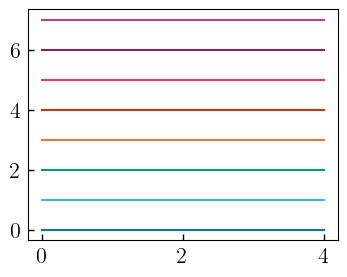

In [6]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from jax import numpy as jnp
from jax import jit as jjit
from jax import vmap
from jax import grad
from jax import random as jran
import os
import h5py
import time

mred = u"#d62728"
morange = u"#ff7f0e"
mgreen = u"#2ca02c"
mblue = u"#1f77b4"
mpurple = u"#9467bd"
fact = 1.0
plt.rcParams["figure.figsize"] = (4*fact, 3*fact)
plt.rc('font', family="serif")
plt.rc('font', size=18)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}') #necessary to use \dfrac
colors = ["#0077BB", "#33BBEE", "#009988", "#EE7733", "#CC3311", "#EE3377", '#882255', '#AA4499']
for i, x in enumerate(colors):
    plt.plot(np.ones(5)*i, color=x)

In [7]:
from diffstar.constants import TODAY
from diffstar.stars import fstar_tools
import astropy.units as u
from astropy.cosmology import Planck13, z_at_value

# Define our cosmci time array to make some predictions
#t_table = np.linspace(0.1, TODAY, 100)
# t_table = np.logspace(-1, np.log10(TODAY), 100)

t_table = np.linspace(1.0, TODAY, 100)
# t_table = (TODAY - Planck13.lookback_time(np.arange(0,2.1,0.5)).value)[::-1]
# t_table = np.concatenate((np.linspace(1.0, 3, 5), t_table))
# t_table = np.clip(t_table, None, TODAY)
z_table = np.array([z_at_value(Planck13.age, x * u.Gyr, zmin=-1) for x in t_table])

t_sel_hists = np.argmin(np.subtract.outer(z_table, np.arange(0,1.1,0.5))**2, axis=0)[::-1]

print(t_table)
print(z_table)
lgt = np.log10(t_table)
# Define some mass bins for predictions
# logm0_binmids = np.linspace(11.5, 13.5, 5)
logm0_binmids = np.linspace(11.0, 14.0, 7)

# logm0_binmids = np.linspace(12.0, 12.5, 3)
logm0_bin_widths = np.ones_like(logm0_binmids) * 0.1


# Define some useful quantities and masks for later
fstar_tdelay = 1.0
index_select, index_high = fstar_tools(t_table, fstar_tdelay=fstar_tdelay)


sm_loss_weight = jnp.where(t_table>2.0, 1.0, 1e10)
fstar_loss_MS_weight = jnp.where(t_table[index_select]>2.0, 1.0, 1e10)
fstar_loss_Q_weight = jnp.where(t_table[index_select]>5.0, 1.0, 1e10)

sm_loss_sel = np.arange(len(t_table))[t_table>1.0]
fstar_loss_MS_sel = np.arange(len(t_table[index_select]))[t_table[index_select]>2.0]
fstar_loss_Q_sel = np.arange(len(t_table[index_select]))[t_table[index_select]>5.0]


[ 1.          1.12929293  1.25858586  1.38787879  1.51717172  1.64646465
  1.77575758  1.90505051  2.03434343  2.16363636  2.29292929  2.42222222
  2.55151515  2.68080808  2.81010101  2.93939394  3.06868687  3.1979798
  3.32727273  3.45656566  3.58585859  3.71515152  3.84444444  3.97373737
  4.1030303   4.23232323  4.36161616  4.49090909  4.62020202  4.74949495
  4.87878788  5.00808081  5.13737374  5.26666667  5.3959596   5.52525253
  5.65454545  5.78383838  5.91313131  6.04242424  6.17171717  6.3010101
  6.43030303  6.55959596  6.68888889  6.81818182  6.94747475  7.07676768
  7.20606061  7.33535354  7.46464646  7.59393939  7.72323232  7.85252525
  7.98181818  8.11111111  8.24040404  8.36969697  8.4989899   8.62828283
  8.75757576  8.88686869  9.01616162  9.14545455  9.27474747  9.4040404
  9.53333333  9.66262626  9.79191919  9.92121212 10.05050505 10.17979798
 10.30909091 10.43838384 10.56767677 10.6969697  10.82626263 10.95555556
 11.08484848 11.21414141 11.34343434 11.47272727 11.60

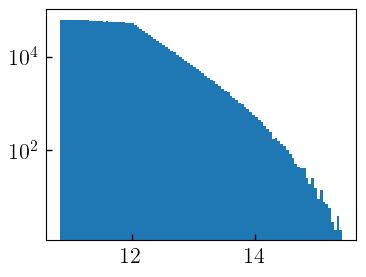

In [8]:
path = "/Users/alarcon/Documents/diffmah_data/SMDPL/"

mah_params_arr = np.load(path+"mah_params_arr_576_small.npy")
u_fit_params_arr = np.load(path+"u_fit_params_arr_576_small.npy")
fit_params_arr = np.load(path+"fit_params_arr_576_small.npy")
p50_arr = np.load(path+"p50_arr_576_small.npy")

logmpeak = mah_params_arr[:,1]

plt.hist(logmpeak, 100)
plt.yscale('log')
plt.show()

In [9]:
normal_values = (mah_params_arr[:, 4] < 4.5)
normal_values &= (mah_params_arr[:, 2] < 2.0)

Nhalos = 2000
halo_data_MC = []
p50 = []
for i in range(len(logm0_binmids)):
    _sel = (logmpeak > logm0_binmids[i] - logm0_bin_widths[i]) & (logmpeak < logm0_binmids[i] + logm0_bin_widths[i])
    _sel &= normal_values
    print(_sel.sum())
    sel = np.random.choice(np.arange(len(p50_arr))[_sel], Nhalos, replace=True)
    halo_data_MC.append(mah_params_arr[sel])
    p50.append(p50_arr[sel])
halo_data_MC = np.concatenate(halo_data_MC, axis=0)[:, np.array([1,2,4,5])]
p50 = np.concatenate(p50, axis=0)


259738
248289
218091
80336
27108
8472
2316


In [10]:
from diffstarpop.pdf_quenched import DEFAULT_SFH_PDF_QUENCH_PARAMS
from diffstarpop.pdf_mainseq import DEFAULT_SFH_PDF_MAINSEQ_PARAMS
from diffstarpop.pdf_model_assembly_bias_shifts import DEFAULT_R_MAINSEQ_PARAMS, DEFAULT_R_QUENCH_PARAMS

N_PDF_Q = len(DEFAULT_SFH_PDF_QUENCH_PARAMS)
N_PDF_MS = len(DEFAULT_SFH_PDF_MAINSEQ_PARAMS)
N_R_Q = len(DEFAULT_R_QUENCH_PARAMS)
N_R_MS = len(DEFAULT_R_MAINSEQ_PARAMS)

from diffstarpop.monte_carlo_diff_halo_population import (
    draw_sfh_MIX_vmap,
    draw_sfh_MIX,
)
def dict_to_array(dictionary):
    return np.array(list(dictionary.values()))

In [8]:
n_histories = int(1e4)
ran_key = jran.PRNGKey(0)

t0 = time.time()
histories = draw_sfh_MIX_vmap(
    t_table,
    logm0_binmids,
    halo_data_MC.reshape(len(logm0_binmids),Nhalos,4),
    p50.reshape(len(logm0_binmids),Nhalos),
    n_histories,
    ran_key,
    index_select,
    index_high,
    fstar_tdelay,
    dict_to_array(DEFAULT_SFH_PDF_QUENCH_PARAMS),
    dict_to_array(DEFAULT_SFH_PDF_MAINSEQ_PARAMS),
    dict_to_array(DEFAULT_R_QUENCH_PARAMS),
    dict_to_array(DEFAULT_R_MAINSEQ_PARAMS),
)
t1 = time.time()
print(t1-t0)

18.21523904800415


In [9]:
histories[0].shape

(7, 20000, 100)

In [11]:
from diffmah.individual_halo_assembly import _calc_halo_history
from diffstar.utils import _get_dt_array
# from diffstarpop.utils import get_t50_p50

_calc_halo_history_vmap = jjit(vmap(_calc_halo_history, in_axes=(None, *[0]*6)))


In [12]:
from dsps.cosmology import DEFAULT_COSMOLOGY
from dsps.data_loaders import load_ssp_templates
from dsps.data_loaders.load_filter_data import load_transmission_curve
from dsps.photometry.utils import interpolate_filter_trans_curves
from dsps.photometry.photpop import precompute_ssp_obsmags_on_z_table

from diffsky.experimental.dspspop.boris_dust import DEFAULT_PARAMS as DEFAULT_BORIS_PARAMS
from diffsky.experimental.dspspop.lgfburstpop import DEFAULT_LGFBURST_U_PARAMS
from diffsky.experimental.dspspop.burstshapepop import DEFAULT_BURSTSHAPE_U_PARAMS
from diffsky.experimental.dspspop.lgavpop import DEFAULT_LGAV_U_PARAMS
from diffsky.experimental.dspspop.dust_deltapop import DEFAULT_DUST_DELTA_U_PARAMS

from diffsky.experimental.dspspop.photpop import get_obs_photometry_singlez

DSPS_data_path = "/Users/alarcon/Documents/DSPS_data/"
DSPS_filter_path = "/Users/alarcon/Documents/DSPS_data/filters/"




def get_gal_colors_from_sfh(gal_t_table, gal_sfr_table, z_obs):

    # gal_t_table = times up to zobs
    # gal_sfr_table = Tabulation of the galaxy SFH in Msun/yr at the times gal_t_table

    # Set cosmology
    cosmo_params = DEFAULT_COSMOLOGY

    # Load ssp data
    ssp_data = load_ssp_templates(drn=DSPS_data_path)
    
    u_filter_data = load_transmission_curve(drn=DSPS_filter_path, bn_pat="lsst_u*")
    g_filter_data = load_transmission_curve(drn=DSPS_filter_path, bn_pat="lsst_g*")
    r_filter_data = load_transmission_curve(drn=DSPS_filter_path, bn_pat="lsst_r*")
    i_filter_data = load_transmission_curve(drn=DSPS_filter_path, bn_pat="lsst_i*")
    z_filter_data = load_transmission_curve(drn=DSPS_filter_path, bn_pat="lsst_z*")

    ssp_lgmet      = ssp_data[0]                                             
    ssp_lg_age_gyr = ssp_data[1]
    ssp_waves      = ssp_data[2]
    ssp_spectra    = ssp_data[3]

    wave_filters = [
        u_filter_data[0], 
        g_filter_data[0], 
        r_filter_data[0], 
        i_filter_data[0], 
        z_filter_data[0],
    ]
    trans_filters = [
        u_filter_data[1], 
        g_filter_data[1], 
        r_filter_data[1], 
        i_filter_data[1], 
        z_filter_data[1],
    ]
    filter_waves, filter_trans = interpolate_filter_trans_curves(wave_filters, trans_filters)

    # Precompute ssp mags for zobs
    args = [ssp_waves, ssp_spectra, filter_waves, filter_trans, np.array((z_obs,)), *cosmo_params,]
    ssp_obs_photmags = precompute_ssp_obsmags_on_z_table(*args)[0]
    ssp_obs_photflux_table = 10**(-0.4*ssp_obs_photmags)

    """
    # LGFBURST pop params
    lgfburst_u_params = DEFAULT_LGFBURST_U_PARAMS
    # Burst shape pop params
    burstshape_u_params = DEFAULT_BURSTSHAPE_U_PARAMS

    # Nagaraj22 Dust Params
    lgav_dust_u_params = DEFAULT_LGAV_U_PARAMS
    delta_dust_u_params = DEFAULT_DUST_DELTA_U_PARAMS
    # Borist dust params
    boris_dust_u_params = DEFAULT_BORIS_PARAMS
    """
    
    lgfburst_u_params = np.array([13.676748, 24.993097, 16.346615, -8.077414, -7.230221, 7.977014, -10.025747, -31.93147, 1.8577358])
    burstshape_u_params = np.array([10.811945, -14.260326, -12.719431, 13.915222, -22.360744, -11.798748, 14.894418, 11.894378, -6.2989817, 14.317399, -25.193857, 10.13922])
    lgav_dust_u_params = np.array([13.403622, 24.446869, 18.417566, 1.7414757, 28.589493, 18.164486, -34.442814, -37.12286, -11.0768175])
    delta_dust_u_params = np.array([3.9146907, 25.844297, 5.9755583, -13.801724, -7.8439326, 17.40668, -29.22427, -1.6012566, -12.697886])
    boris_dust_u_params = np.array([7.4935946, -8.661586, 7.034099, -1.7708112, 0.87082285, -19.434017, 14.279153, -8.100566, 2.7693071, 15.053559, 32.051685, -40.424793, -16.915089, -21.71999, -38.98167, -13.244473, -2.2783546, 29.663462, 45.44704, -30.58583, -15.197127])
    
    # Calculate galaxy fluxes (including metallicity, dust, and burstiness)
    # default met_params, lgmet_scatter=0.2
    res = get_obs_photometry_singlez(ran_key, filter_waves, filter_trans, 
                                    ssp_obs_photflux_table, ssp_lgmet, ssp_lg_age_gyr, 
                                    gal_t_table, gal_sfr_table, 
                                    lgfburst_u_params, burstshape_u_params, 
                                    lgav_dust_u_params, delta_dust_u_params, boris_dust_u_params, 
                                    cosmo_params, z_obs)


    (
        weights,
        lgmet_weights,
        smooth_age_weights,
        bursty_age_weights,
        frac_trans,
        gal_obsflux_nodust,
        gal_obsflux
    ) = res


    # Magnitudes
    galpop_obs_mags = -2.5 * np.log10(gal_obsflux)

    return galpop_obs_mags


In [11]:
bin_id = 6
gal_sfr_table = histories[1][bin_id,:]
zobs = 0.1
weight = histories[4][bin_id]

t0 = time.time()
mags = get_gal_colors_from_sfh(t_table, gal_sfr_table, zobs)

t1 = time.time()
print(t1-t0)

2.934270143508911


In [12]:
gal_colors = -np.diff(mags, axis=1)

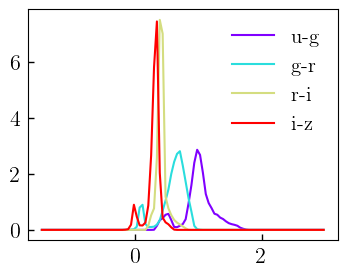

In [13]:
colors = plt.get_cmap("rainbow")(np.linspace(0,1,4))#[::-1]

colors_names = ["u-g", "g-r", "r-i", "i-z"]

bins = np.linspace(-1.5, 3, 100)
binsc = 0.5*(bins[1:]+bins[:-1])
for i, x in enumerate(gal_colors.T):

    counts = np.histogram(x, bins, weights=weight, density=1)[0]
    plt.plot(binsc, counts, label=colors_names[i], color=colors[i])
    
plt.legend()

In [176]:
np.diff(np.arange(5))

array([1, 1, 1, 1])

In [133]:
logm0_binmids[bin_id], zobs

(12.5, 0.5)

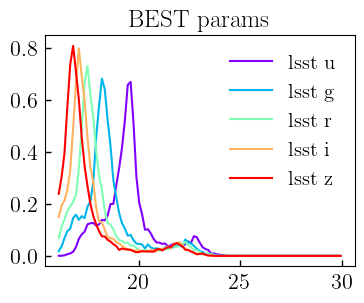

In [141]:
colors = plt.get_cmap("rainbow")(np.linspace(0,1,5))
mag_names = ["u", "g", "r", "i", "z"]
mag_names = ["lsst %s"%x for x in mag_names]
bins = np.linspace(16, 30, 100)
binsc = 0.5*(bins[1:]+bins[:-1])
for i, x in enumerate(mags.T):
    counts = np.histogram(x, bins, weights=weight, density=1)[0]
    # plt.hist(x, _bins, histtype='step', label=mag_names[i], color=colors[i], weights=weight)
    plt.plot(binsc, counts, label=mag_names[i], color=colors[i])
    
plt.legend()
plt.title("BEST params")
plt.show()
    

0.6335921287536621
0.5660648345947266
0.517988920211792
0.5510849952697754
0.5202810764312744
0.5245151519775391
0.5238151550292969


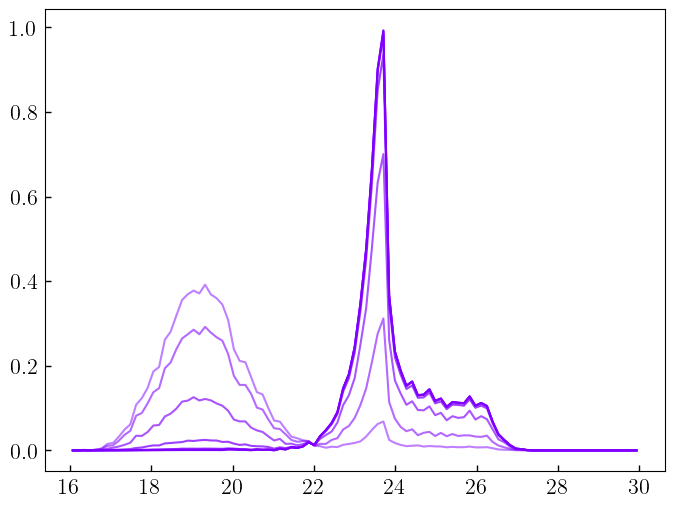

0.5152640342712402
0.5359330177307129
0.5364511013031006
0.5265510082244873
0.5205700397491455
0.5308983325958252
0.5183820724487305


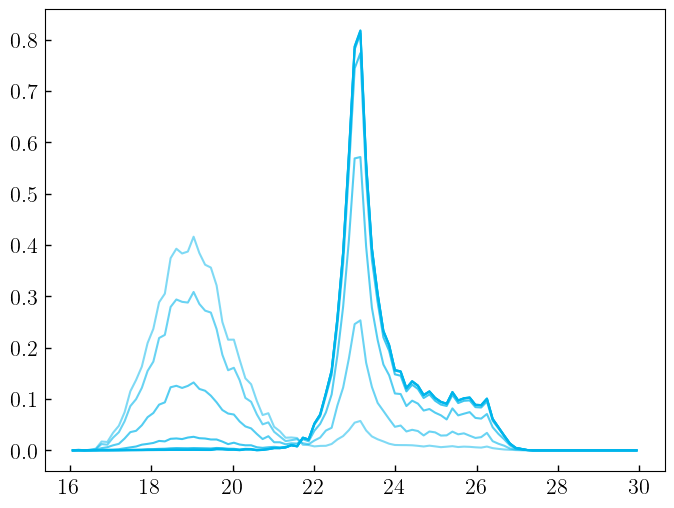

0.523651123046875
0.5065650939941406
0.5684628486633301
0.5259079933166504
0.5373220443725586
0.522273063659668
0.5113842487335205


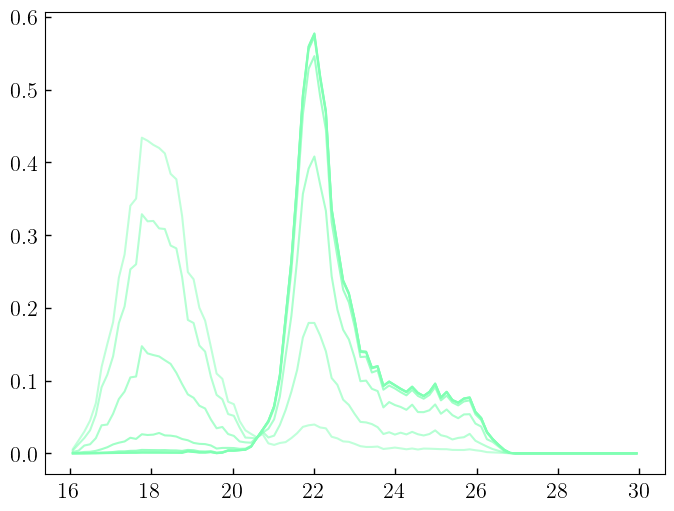

0.530116081237793
0.5522351264953613
0.48947978019714355
0.5047421455383301
0.5154609680175781
0.5286939144134521
0.5237710475921631


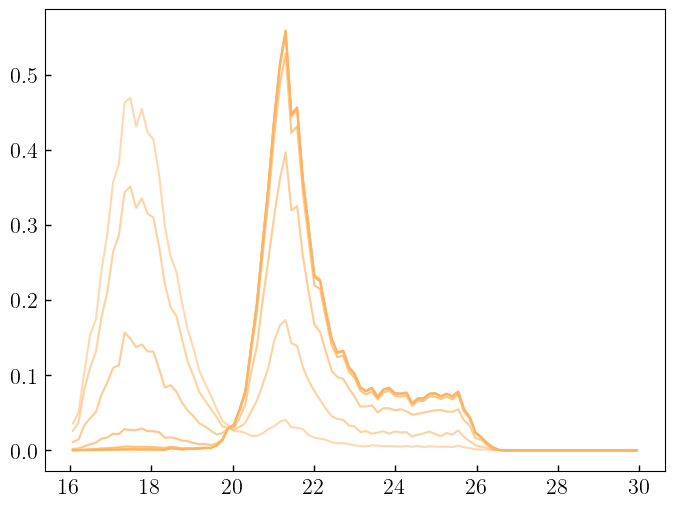

0.5806379318237305
0.5140817165374756
0.5094249248504639
0.5093162059783936
0.5059208869934082
0.546766996383667
0.5652921199798584


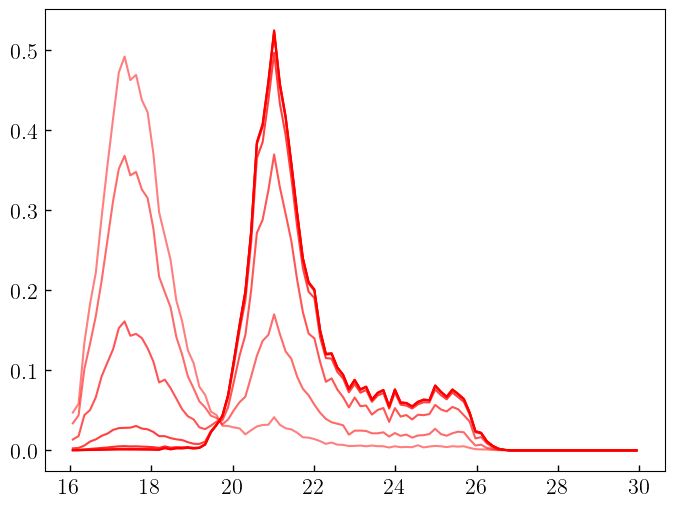

In [107]:
colors = plt.get_cmap("rainbow")(np.linspace(0,1,5))
mag_names = ["u", "g", "r", "i", "z"]
mag_names = ["lsst %s"%x for x in mag_names]
bins = np.linspace(16, 30, 100)
binsc = 0.5*(bins[1:]+bins[:-1])

shades = np.linspace(0.5, 1, len(logm0_binmids))



for i, x in enumerate(mags.T):
    
    plt.figure(figsize=(8,6))
    for bin_id in range(len(logm0_binmids)):
        gal_sfr_table = histories[1][bin_id,:]
        zobs = 0.5
        weight = histories[4][bin_id]

        t0 = time.time()
        mags = get_gal_colors_from_sfh(t_table, gal_sfr_table, zobs)

        t1 = time.time()
        print(t1-t0)

    
        counts = np.histogram(x, bins, weights=weight, density=1)[0]
        _c = colors[i].copy()
        _c[3] = shades[bin_id]
        # plt.hist(x, _bins, histtype='step', label=mag_names[i], color=colors[i], weights=weight)
        plt.plot(binsc, counts, label=mag_names[i], color=_c)
    
    # plt.legend()
    # plt.title("BEST params")
    plt.show()

In [13]:
def precompute_DSPS_data(z_arr):
    cosmo_params = DEFAULT_COSMOLOGY

    # Load ssp data
    ssp_data = load_ssp_templates(drn=DSPS_data_path)
    
    u_filter_data = load_transmission_curve(drn=DSPS_filter_path, bn_pat="lsst_u*")
    g_filter_data = load_transmission_curve(drn=DSPS_filter_path, bn_pat="lsst_g*")
    r_filter_data = load_transmission_curve(drn=DSPS_filter_path, bn_pat="lsst_r*")
    i_filter_data = load_transmission_curve(drn=DSPS_filter_path, bn_pat="lsst_i*")
    z_filter_data = load_transmission_curve(drn=DSPS_filter_path, bn_pat="lsst_z*")

    ssp_lgmet      = ssp_data[0]                                             
    ssp_lg_age_gyr = ssp_data[1]
    ssp_waves      = ssp_data[2]
    ssp_spectra    = ssp_data[3]

    wave_filters = [
        u_filter_data[0], 
        g_filter_data[0], 
        r_filter_data[0], 
        i_filter_data[0], 
        z_filter_data[0],
    ]
    trans_filters = [
        u_filter_data[1], 
        g_filter_data[1], 
        r_filter_data[1], 
        i_filter_data[1], 
        z_filter_data[1],
    ]
    filter_waves, filter_trans = interpolate_filter_trans_curves(wave_filters, trans_filters)
    
    lgfburst_u_params = np.array([13.676748, 24.993097, 16.346615, -8.077414, -7.230221, 7.977014, -10.025747, -31.93147, 1.8577358])
    burstshape_u_params = np.array([10.811945, -14.260326, -12.719431, 13.915222, -22.360744, -11.798748, 14.894418, 11.894378, -6.2989817, 14.317399, -25.193857, 10.13922])
    lgav_dust_u_params = np.array([13.403622, 24.446869, 18.417566, 1.7414757, 28.589493, 18.164486, -34.442814, -37.12286, -11.0768175])
    delta_dust_u_params = np.array([3.9146907, 25.844297, 5.9755583, -13.801724, -7.8439326, 17.40668, -29.22427, -1.6012566, -12.697886])
    boris_dust_u_params = np.array([7.4935946, -8.661586, 7.034099, -1.7708112, 0.87082285, -19.434017, 14.279153, -8.100566, 2.7693071, 15.053559, 32.051685, -40.424793, -16.915089, -21.71999, -38.98167, -13.244473, -2.2783546, 29.663462, 45.44704, -30.58583, -15.197127])
            
    ssp_obs_photflux_table_arr = []
    for z_obs in z_arr:
        # Precompute ssp mags for zobs
        args = [ssp_waves, ssp_spectra, filter_waves, filter_trans, np.array((z_obs,)), *cosmo_params,]
        ssp_obs_photmags = precompute_ssp_obsmags_on_z_table(*args)[0]
        ssp_obs_photflux_table = 10**(-0.4*ssp_obs_photmags)
        ssp_obs_photflux_table_arr.append(ssp_obs_photflux_table)
        
    ssp_obs_photflux_table_arr = np.array(ssp_obs_photflux_table_arr)
        
    dsps_data = (
        filter_waves, 
        filter_trans,
        ssp_lgmet, 
        ssp_lg_age_gyr,
        lgfburst_u_params,
        burstshape_u_params,
        lgav_dust_u_params,
        delta_dust_u_params,
        boris_dust_u_params,
        cosmo_params,
    )
    
    return ssp_obs_photflux_table_arr, dsps_data


@jjit
def get_colors_kern(gal_t_table, gal_sfr_table, z_obs, ssp_obs_photflux_table, dsps_data, ran_key):
    (
        filter_waves, 
        filter_trans,
        ssp_lgmet, 
        ssp_lg_age_gyr,
        lgfburst_u_params,
        burstshape_u_params,
        lgav_dust_u_params,
        delta_dust_u_params,
        boris_dust_u_params,
        cosmo_params,
    ) = dsps_data

    res = get_obs_photometry_singlez(ran_key, filter_waves, filter_trans, 
                                        ssp_obs_photflux_table, ssp_lgmet, ssp_lg_age_gyr, 
                                        gal_t_table, gal_sfr_table, 
                                        lgfburst_u_params, burstshape_u_params, 
                                        lgav_dust_u_params, delta_dust_u_params, boris_dust_u_params, 
                                        cosmo_params, z_obs)


    (
        weights,
        lgmet_weights,
        smooth_age_weights,
        bursty_age_weights,
        frac_trans,
        gal_obsflux_nodust,
        gal_obsflux
    ) = res


    # Magnitudes
    galpop_obs_mags = -2.5 * jnp.log10(gal_obsflux)

    return galpop_obs_mags
    
_A = (None, None, 0, 0, None, None)
get_colors = jjit(vmap(get_colors_kern, in_axes=_A))



In [15]:
ran_key = jran.PRNGKey(0)

z_arr = np.array([0.1, 0.5, 1.0])
ssp_obs_photflux_table_arr, dsps_data = precompute_DSPS_data(z_arr)

_ids = np.argmin(np.subtract.outer(z_table, z_arr)**2, axis=0)[::-1]
gal_sfr_table = histories[1][bin_id,:]# [:, _ids].T

t0 = time.time()
mags = get_colors(t_table, gal_sfr_table, z_arr, ssp_obs_photflux_table_arr, dsps_data, ran_key)
t1 = time.time()
print(t1-t0)

3.6723268032073975


In [35]:
mags.shape, len(logm0_binmids)

((3, 20000, 5), 7)

In [36]:
jnp.diff(mags[0], axis=1).shape
    

(20000, 4)

In [148]:
mags = get_gal_colors_from_sfh(t_table, gal_sfr_table, zobs)




(20000, 3)

In [14]:
from diffsky.diffndhist import tw_ndhist_weighted
from diffstarpop.utils import _tw_cuml_lax_kern
_tw_cuml_lax_kern_vmap = jjit(vmap(_tw_cuml_lax_kern, in_axes=(0, None, None)))

from functools import partial
from diffstarpop.monte_carlo_diff_halo_population import (
    _tw_cuml_lax_kern_vmap,
    compute_sumstats_MIX_p50,
    calc_hist_mstar_ssfr,
)

@jjit
def calc_hist_kern(
    arrA, arrB, ndsig, weight, ndbins_lo, ndbins_hi
):
    eps = 1e-10

    nddata = jnp.array([arrA, arrB]).T
    counts = tw_ndhist_weighted(nddata, ndsig, weight, ndbins_lo, ndbins_hi)
    counts = jnp.clip(counts, eps, None)
    counts = counts / jnp.sum(counts)
    return counts


calc_hist = jjit(
    vmap(calc_hist_kern, in_axes=(0, 0, None, *[None] * 3 ))
)

@jjit
def calculate_counts_mag_colors_bin(
    gal_mags,
    weight,
    ndsig_colmag,
    ndsig_colcol,
    bins_LO_colcol,
    bins_HI_colcol,
    bins_LO_colmag,
    bins_HI_colmag,
):
        
    imag = gal_mags[:, :, 3] # i-band
    gal_col = -jnp.diff(gal_mags, axis=2) # u-g, g-r, r-i, i-z

    # nzarr, nhist = imag.shape
    # weights_magcut = _tw_cuml_lax_kern_vmap(imag, 25.0, 0.2)
    # weights_magcut = weights_magcut.reshape(nzarr, nhist)
    # weights_magcut = 1.0 - weights_magcut # so it's 1 for brigther (smaller) magnitudes.

    counts_i_ug = calc_hist(
        imag, gal_col[:,:,0], ndsig_colmag, weight, bins_LO_colmag, bins_HI_colmag
    )
    counts_i_gr = calc_hist(
        imag, gal_col[:,:,1], ndsig_colmag, weight, bins_LO_colmag, bins_HI_colmag
    )
    counts_i_ri = calc_hist(
        imag, gal_col[:,:,2], ndsig_colmag, weight, bins_LO_colmag, bins_HI_colmag
    )
    counts_i_iz = calc_hist(
        imag, gal_col[:,:,3], ndsig_colmag, weight, bins_LO_colmag, bins_HI_colmag
    )
    
    counts_ug_gr = calc_hist(
        gal_col[:,:,0], gal_col[:,:,1], ndsig_colcol, weight, bins_LO_colcol, bins_HI_colcol
    )
    counts_gr_ri = calc_hist(
        gal_col[:,:,1], gal_col[:,:,2], ndsig_colcol, weight, bins_LO_colcol, bins_HI_colcol
    )
    counts_ri_iz = calc_hist(
        gal_col[:,:,2], gal_col[:,:,3], ndsig_colcol, weight, bins_LO_colcol, bins_HI_colcol
    )
    
    out = (
        counts_i_ug,
        counts_i_gr,
        counts_i_ri,
        counts_i_iz,
        counts_ug_gr,
        counts_gr_ri,
        counts_ri_iz,
    )
    
    return out

@partial(jjit, static_argnames=["n_histories"])
def sumstats_sfh_colmags(
    t_table,
    logmh,
    mah_params,
    p50,
    n_histories,
    ran_key,
    index_select,
    index_high,
    fstar_tdelay,
    ndsig_colcol,
    ndsig_colmag,
    bins_LO_colcol,
    bins_HI_colcol,
    bins_LO_colmag,
    bins_HI_colmag,
    z_arr, 
    dsps_data,
    ssp_obs_photflux_table_arr,
    pdf_parameters_Q=DEFAULT_SFH_PDF_QUENCH_PARAMS,
    pdf_parameters_MS=DEFAULT_SFH_PDF_MAINSEQ_PARAMS,
    R_model_params_Q=DEFAULT_R_QUENCH_PARAMS,
    R_model_params_MS=DEFAULT_R_MAINSEQ_PARAMS,
):
    
    sfh_key, ssp_key = jran.split(ran_key, 2)
    
    mstar, sfr, fstar, p50_sampled, weight = draw_sfh_MIX(
        t_table,
        logmh,
        mah_params,
        p50,
        n_histories,
        sfh_key,
        index_select,
        index_high,
        fstar_tdelay,
        pdf_parameters_Q,
        pdf_parameters_MS,
        R_model_params_Q,
        R_model_params_MS,
    )

    ssfr = sfr / mstar
    # weights_quench_bin = jnp.where(ssfr > 1e-11, 1.0, 0.0)
    nhist, nt = ssfr.shape
    ssfr = jnp.where(ssfr > 0.0, jnp.log10(ssfr), -50.0)
    weights_quench_bin = _tw_cuml_lax_kern_vmap(ssfr.reshape(nhist * nt), -11.0, 0.2)
    weights_quench_bin = weights_quench_bin.reshape(nhist, nt)

    mstar = jnp.where(mstar > 0.0, jnp.log10(mstar), 0.0)
    log_sfr = jnp.where(sfr > 0.0, jnp.log10(sfr), 0.0)

    _res = compute_sumstats_MIX_p50(mstar, log_sfr, p50_sampled, weights_quench_bin, weight)
    (
        mean_sm,
        variance_sm,
        mean_sfr_MS,
        mean_sfr_Q,
        variance_sfr_MS,
        variance_sfr_Q,
        quench_frac,
        mean_sm_early,
        mean_sm_late,
        variance_sm_early,
        variance_sm_late,
        quench_frac_early,
        quench_frac_late,
    ) = _res
        
        
    gal_mags = get_colors(t_table, sfr, z_arr, ssp_obs_photflux_table_arr, dsps_data, ssp_key)

    _res = calculate_counts_mag_colors_bin(
        gal_mags,
        weight,
        ndsig_colmag,
        ndsig_colcol,
        bins_LO_colcol,
        bins_HI_colcol,
        bins_LO_colmag,
        bins_HI_colmag,
    )
    
    (
        counts_i_ug,
        counts_i_gr,
        counts_i_ri,
        counts_i_iz,
        counts_ug_gr,
        counts_gr_ri,
        counts_ri_iz,
    ) = _res

    out = (
        mean_sm,
        variance_sm,
        mean_sfr_MS,
        mean_sfr_Q,
        variance_sfr_MS,
        variance_sfr_Q,
        quench_frac,
        mean_sm_early,
        mean_sm_late,
        variance_sm_early,
        variance_sm_late,
        quench_frac_early,
        quench_frac_late,
        counts_i_ug,
        counts_i_gr,
        counts_i_ri,
        counts_i_iz,
        counts_ug_gr,
        counts_gr_ri,
        counts_ri_iz,
    )
    return out


_A = (None, 0, 0, 0, *[None] * 18)
sumstats_sfh_colmags_vmap = jjit(
    vmap(sumstats_sfh_colmags, in_axes=_A), static_argnames=["n_histories"]
)



In [15]:
bins_color = jnp.linspace(-1, 2.5, 25)
bins_magn = jnp.linspace(15, 25, 25)
delta_bins_color = float(jnp.diff(bins_color)[0])
delta_bins_magn = float(jnp.diff(bins_magn)[0])

bins_LO_colcol = []
bins_HI_colcol = []
for i in range(len(bins_color)-1):
    for j in range(len(bins_color)-1):
        bins_LO_colcol.append([bins_color[i], bins_color[j]])
        bins_HI_colcol.append([bins_color[i+1], bins_color[j+1]])
bins_LO_colcol = np.array(bins_LO_colcol)
bins_HI_colcol = np.array(bins_HI_colcol)
print(bins_LO_colcol.shape, bins_HI_colcol.shape)

bins_LO_colmag = []
bins_HI_colmag = []
for i in range(len(bins_magn)-1):
    for j in range(len(bins_color)-1):
        bins_LO_colmag.append([bins_magn[i], bins_color[j]])
        bins_HI_colmag.append([bins_magn[i+1], bins_color[j+1]])
bins_LO_colmag = np.array(bins_LO_colmag)
bins_HI_colmag = np.array(bins_HI_colmag)
print(bins_LO_colmag.shape, bins_HI_colmag.shape)


(576, 2) (576, 2)
(576, 2) (576, 2)


In [12]:
n_histories = int(1e3)
ran_key = jran.PRNGKey(0)

ndsig_colcol = np.ones((2*n_histories, 2))
ndsig_colcol[:,0] *= delta_bins_color
ndsig_colcol[:,1] *= delta_bins_color

ndsig_colmag = np.ones((2*n_histories, 2))
ndsig_colmag[:,0] *= delta_bins_magn
ndsig_colmag[:,1] *= delta_bins_color

z_arr = np.array([0.1, 0.5, 1.0])

ssp_obs_photflux_table_arr, dsps_data = precompute_DSPS_data(z_arr)


t0 = time.time()
_res = sumstats_sfh_colmags_vmap(
    t_table,
    logm0_binmids,
    halo_data_MC.reshape(len(logm0_binmids),Nhalos,4),
    p50.reshape(len(logm0_binmids),Nhalos),
    n_histories,
    ran_key,
    index_select,
    index_high,
    fstar_tdelay,
    ndsig_colcol,
    ndsig_colmag,
    bins_LO_colcol,
    bins_HI_colcol,
    bins_LO_colmag,
    bins_HI_colmag,
    z_arr, 
    dsps_data,
    ssp_obs_photflux_table_arr,
    dict_to_array(DEFAULT_SFH_PDF_QUENCH_PARAMS),
    dict_to_array(DEFAULT_SFH_PDF_MAINSEQ_PARAMS),
    dict_to_array(DEFAULT_R_QUENCH_PARAMS),
    dict_to_array(DEFAULT_R_MAINSEQ_PARAMS),
)
t1 = time.time()
print(t1-t0)

12.504204034805298


In [16]:
from diffstarpop.monte_carlo_diff_halo_population import (
    sm_sfr_history_diffstar_scan_XsfhXmah_vmap,
    sm_sfr_history_diffstar_scan_MS_XsfhXmah_vmap,
    _jax_get_dt_array

)
def calculate_SMDPL_sumstats(
    t_table,
    logm0_binmids,
    logm0_bin_widths,
    mah_params, 
    fit_params, 
    p50,
    z_arr, 
    ssp_obs_photflux_table_arr, 
    dsps_data,
    bins_LO_colcol,
    bins_HI_colcol,
    bins_LO_colmag,
    bins_HI_colmag,
):
    logmpeak = mah_params[:, 1]

    lgt = np.log10(t_table)

    fstar_tdelay = 1.0
    index_select, index_high = fstar_tools(t_table, fstar_tdelay=fstar_tdelay)
    dt = _jax_get_dt_array(t_table)

    stats = []
    for i in range(len(logm0_binmids)):

        print("Calculating m0=[%.2f, %.2f]"%(logm0_binmids[i] - logm0_bin_widths[i], logm0_binmids[i] + logm0_bin_widths[i]))
        sel = (logmpeak > logm0_binmids[i] - logm0_bin_widths[i]) & (logmpeak < logm0_binmids[i] + logm0_bin_widths[i])
        print("Nhalos:", sel.sum())
        _res = sm_sfr_history_diffstar_scan_XsfhXmah_vmap(
            t_table,
            lgt,
            dt,
            mah_params[sel][:, [1,2,4,5]],
            fit_params[sel][:,[0,1,2,4]].copy(),
            fit_params[sel][:,[5,6,7,8]].copy(),
            index_select,
            index_high,
            fstar_tdelay,
        )
        
        (
            mstar_histories,
            sfr_histories,
            fstar_histories,
        ) = _res
        
        ssfr = sfr_histories / mstar_histories
        weights_quench_bin = jnp.where(ssfr > 1e-11, 1.0, 0.0)
        
        ran_key = jran.PRNGKey(np.random.randint(2**32))
        
        n_histories = len(mstar_histories)
        ndsig_colcol = np.ones((n_histories, 2))
        ndsig_colcol[:,0] *= delta_bins_color
        ndsig_colcol[:,1] *= delta_bins_color

        ndsig_colmag = np.ones((n_histories, 2))
        ndsig_colmag[:,0] *= delta_bins_magn
        ndsig_colmag[:,1] *= delta_bins_color


        _stats = calculate_sumstats_bin(
            mstar_histories, 
            sfr_histories, 
            p50[sel], 
            weights_quench_bin,
            z_arr, 
            ssp_obs_photflux_table_arr, 
            dsps_data,
            ran_key,
            ndsig_colmag,
            ndsig_colcol,
            bins_LO_colcol,
            bins_HI_colcol,
            bins_LO_colmag,
            bins_HI_colmag,
        )
        stats.append(_stats)

    print("Reshaping results")
        
    new_stats = []
    nres = len(_stats)
    for j in range(nres):
        _new_stats = []
        for i in range(len(logm0_binmids)):
            _new_stats.append(stats[i][j])
        new_stats.append(np.array(_new_stats))


    # np.save("/Users/alarcon/Documents/diffmah_data/SMDPL_sfh_sumstats.npy", new_stats)
    return new_stats



def calculate_sumstats_bin(
    mstar_histories, 
    sfr_histories, 
    p50, 
    weights_MS,
    z_arr, 
    ssp_obs_photflux_table_arr, 
    dsps_data,
    ssp_key,
    ndsig_colmag,
    ndsig_colcol,
    bins_LO_colcol,
    bins_HI_colcol,
    bins_LO_colmag,
    bins_HI_colmag,
):

    weights_Q = 1.0 - weights_MS

    # Clip weights. When all weights in a time
    # step are 0, Nans will occur in gradients.
    eps = 1e-10
    weights_Q = jnp.clip(weights_Q, eps, None)
    weights_MS = jnp.clip(weights_MS, eps, None)

    weights_early = jnp.where(p50 < 0.5, 1.0, 0.0)
    weights_late = 1.0 - weights_early
    weights_early = jnp.clip(weights_early, eps, None)
    weights_late = jnp.clip(weights_late, eps, None)

    ssfr = sfr_histories / mstar_histories
    
    mstar_histories = jnp.where(mstar_histories > 0.0, jnp.log10(mstar_histories), 0.0)
    log_sfr_histories = jnp.where(sfr_histories > 0.0, jnp.log10(sfr_histories), 0.0)
    
    ssfr = jnp.where(ssfr > 0.0, jnp.log10(ssfr), -50.0)

    mean_sm = jnp.average(mstar_histories, axis=0)
    mean_sfr_MS = jnp.average(log_sfr_histories, weights=weights_MS, axis=0)
    mean_sfr_Q = jnp.average(log_sfr_histories, weights=weights_Q, axis=0)

    mean_sm_early = jnp.average(mstar_histories, weights=weights_early, axis=0)
    mean_sm_late = jnp.average(mstar_histories, weights=weights_late, axis=0)

    variance_sm = jnp.average(
        (mstar_histories - mean_sm[None, :]) ** 2, axis=0,
    )

    variance_sfr_MS = jnp.average(
        (log_sfr_histories - mean_sfr_MS[None, :]) ** 2, weights=weights_MS, axis=0,
    )
    variance_sfr_Q = jnp.average(
        (log_sfr_histories - mean_sfr_Q[None, :]) ** 2, weights=weights_Q, axis=0,
    )
    variance_sm_early = jnp.average(
        (mstar_histories - mean_sm[None, :]) ** 2, weights=weights_early, axis=0,
    )
    variance_sm_late = jnp.average(
        (mstar_histories - mean_sm[None, :]) ** 2, weights=weights_late, axis=0,
    )

    NHALO_MS = jnp.sum(weights_MS, axis=0)
    NHALO_Q = jnp.sum(weights_Q, axis=0)
    quench_frac = NHALO_Q / (NHALO_Q + NHALO_MS)

    mean_sfr_Q = jnp.where(quench_frac == 0.0, 0.0, mean_sfr_Q)
    variance_sfr_Q = jnp.where(quench_frac == 0.0, 0.0, variance_sfr_Q)
    mean_sfr_MS = jnp.where(quench_frac == 1.0, 0.0, mean_sfr_MS)
    variance_sfr_MS = jnp.where(quench_frac == 1.0, 0.0, variance_sfr_MS)

    NHALO_MS_early = jnp.sum(weights_MS * weights_early[:, None], axis=0)
    NHALO_Q_early = jnp.sum(weights_Q * weights_early[:, None], axis=0)
    quench_frac_early = NHALO_Q_early / (NHALO_Q_early + NHALO_MS_early)

    NHALO_MS_late = jnp.sum(weights_MS * weights_late[:, None], axis=0)
    NHALO_Q_late = jnp.sum(weights_Q * weights_late[:, None], axis=0)
    quench_frac_late = NHALO_Q_late / (NHALO_Q_late + NHALO_MS_late)
    
    
    gal_mags = get_colors(t_table, sfr_histories, z_arr, ssp_obs_photflux_table_arr, dsps_data, ssp_key)

    weight = jnp.ones(len(sfr_histories))
    _res = calculate_counts_mag_colors_bin(
        gal_mags,
        weight,
        ndsig_colmag,
        ndsig_colcol,
        bins_LO_colcol,
        bins_HI_colcol,
        bins_LO_colmag,
        bins_HI_colmag,
    )
    
    (
        counts_i_ug,
        counts_i_gr,
        counts_i_ri,
        counts_i_iz,
        counts_ug_gr,
        counts_gr_ri,
        counts_ri_iz,
    ) = _res
    
    
    _out = (
        mean_sm,
        variance_sm,
        mean_sfr_MS,
        mean_sfr_Q,
        variance_sfr_MS,
        variance_sfr_Q,
        quench_frac,
        mean_sm_early,
        mean_sm_late,
        variance_sm_early,
        variance_sm_late,
        quench_frac_early,
        quench_frac_late,
        counts_i_ug,
        counts_i_gr,
        counts_i_ri,
        counts_i_iz,
        counts_ug_gr,
        counts_gr_ri,
        counts_ri_iz,
    )
    return _out

z_arr = np.array([0.1, 0.5, 1.0])

ssp_obs_photflux_table_arr, dsps_data = precompute_DSPS_data(z_arr)

MC_res_target = calculate_SMDPL_sumstats(
    t_table,
    logm0_binmids,
    logm0_bin_widths,
    mah_params_arr, 
    u_fit_params_arr, 
    p50_arr,
    z_arr, 
    ssp_obs_photflux_table_arr, 
    dsps_data,
    bins_LO_colcol,
    bins_HI_colcol,
    bins_LO_colmag,
    bins_HI_colmag,
)


Calculating m0=[10.90, 11.10]
Nhalos: 264007
Calculating m0=[11.40, 11.60]
Nhalos: 251579
Calculating m0=[11.90, 12.10]
Nhalos: 221115
Calculating m0=[12.40, 12.60]
Nhalos: 81419
Calculating m0=[12.90, 13.10]
Nhalos: 27465
Calculating m0=[13.40, 13.60]
Nhalos: 8594
Calculating m0=[13.90, 14.10]
Nhalos: 2373
Reshaping results


In [17]:
from diffstarpop.fit_pop_helpers import *
@partial(jjit, static_argnames=["n_histories"])
def loss_colors(params, loss_data, n_histories, ran_key):
    (
        t_table,
        logm0_binmids,
        halo_data,
        p50,
        index_select,
        index_high,
        sfr_tdelay,
        ndsig_colcol,
        ndsig_colmag,
        bins_LO_colcol,
        bins_HI_colcol,
        bins_LO_colmag,
        bins_HI_colmag,
        z_arr, 
        dsps_data,
        ssp_obs_photflux_table_arr,
        target_data,
    ) = loss_data
    (
        mean_sm_target,
        variance_sm_target,
        mean_sfr_MS_target,
        mean_sfr_Q_target,
        variance_sfr_MS_target,
        variance_sfr_Q_target,
        quench_frac_target,
        mean_sm_early_target,
        mean_sm_late_target,
        variance_sm_early_target,
        variance_sm_late_target,
        quench_frac_early_target,
        quench_frac_late_target,
        counts_i_ug_target,
        counts_i_gr_target,
        counts_i_ri_target,
        counts_i_iz_target,
        counts_ug_gr_target,
        counts_gr_ri_target,
        counts_ri_iz_target,
    ) = target_data

    _npar = 0
    pdf_q_params = params[_npar : _npar + N_PDF_Q]
    _npar += N_PDF_Q
    pdf_ms_params = params[_npar : _npar + N_PDF_MS]
    _npar += N_PDF_MS
    r_q_params = params[_npar : _npar + N_R_Q]
    _npar += N_R_Q
    r_ms_params = params[_npar : _npar + N_R_MS]

    _res = 
    (
        t_table,
        logm0_binmids,
        halo_data,
        p50,
        n_histories,
        ran_key,
        index_select,
        index_high,
        sfr_tdelay,
        ndsig_colcol,
        ndsig_colmag,
        bins_LO_colcol,
        bins_HI_colcol,
        bins_LO_colmag,
        bins_HI_colmag,
        z_arr, 
        dsps_data,
        ssp_obs_photflux_table_arr,
        pdf_q_params,
        pdf_ms_params,
        r_q_params,
        r_ms_params,
    )
    (
        mean_sm,
        variance_sm,
        mean_sfr_MS,
        mean_sfr_Q,
        variance_sfr_MS,
        variance_sfr_Q,
        quench_frac,
        mean_sm_early,
        mean_sm_late,
        variance_sm_early,
        variance_sm_late,
        quench_frac_early,
        quench_frac_late,
        counts_i_ug,
        counts_i_gr,
        counts_i_ri,
        counts_i_iz,
        counts_ug_gr,
        counts_gr_ri,
        counts_ri_iz,
    ) = _res

    loss = mse(mean_sm, mean_sm_target)
    loss += mse(mean_sm_early, mean_sm_early_target)
    loss += mse(mean_sm_late, mean_sm_late_target)

    # loss += 100 * mse(counts, counts_target)
    loss += (1.0 / 20.0) * mse_arch(counts_ug_gr, counts_ug_gr_target)
    loss += (1.0 / 20.0) * mse_arch(counts_ug_gr, counts_ug_gr_target)
    loss += (1.0 / 20.0) * mse_arch(counts_gr_ri, counts_gr_ri_target)
    loss += (1.0 / 20.0) * mse_arch(counts_i_gr, counts_i_gr_target)


    return loss

loss_colors_deriv = jjit(
    grad(loss_colors, argnums=(0)), static_argnames=["n_histories"]
)

In [18]:
from diffstarpop.json_utils import load_params, write_params_json, print_all_default_dicts
path_json = "/Users/alarcon/Documents/source/diffstarpop/diffstarpop/bestfit_diffstarpop_params_UM_hists_v4.json"
outputs = load_params(path_json)


In [19]:
from jax.example_libraries import optimizers as jax_opt

In [32]:
n_histories = int(1e3)
n_step = int(1e4)
step_size=0.01


N_PDF_Q = len(DEFAULT_SFH_PDF_QUENCH_PARAMS)
N_PDF_MS = len(DEFAULT_SFH_PDF_MAINSEQ_PARAMS)
N_R_Q = len(DEFAULT_R_QUENCH_PARAMS)
N_R_MS = len(DEFAULT_R_MAINSEQ_PARAMS)

ndsig_colcol = np.ones((2*n_histories, 2))
ndsig_colcol[:,0] *= delta_bins_color
ndsig_colcol[:,1] *= delta_bins_color

ndsig_colmag = np.ones((2*n_histories, 2))
ndsig_colmag[:,0] *= delta_bins_magn
ndsig_colmag[:,1] *= delta_bins_color

_loss_data = (
    t_table,
    logm0_binmids,
    halo_data_MC.reshape(len(logm0_binmids),Nhalos,4),
    p50.reshape(len(logm0_binmids),Nhalos),
    index_select,
    index_high,
    fstar_tdelay,
    ndsig_colcol,
    ndsig_colmag,
    bins_LO_colcol,
    bins_HI_colcol,
    bins_LO_colmag,
    bins_HI_colmag,
    z_arr, 
    dsps_data,
    ssp_obs_photflux_table_arr,
    MC_res_target
)
"""
init_guess = np.concatenate((
    dict_to_array(DEFAULT_SFH_PDF_QUENCH_PARAMS),
    dict_to_array(DEFAULT_SFH_PDF_MAINSEQ_PARAMS),
    dict_to_array(DEFAULT_R_QUENCH_PARAMS),
    dict_to_array(DEFAULT_R_MAINSEQ_PARAMS),
))
"""
init_guess = outputs[0].copy()




params_init = init_guess.copy()
ran_key = jran.PRNGKey(np.random.randint(2**32))

loss_arr = np.zeros(n_step).astype("f4") + np.inf

opt_init, opt_update, get_params = jax_opt.adam(step_size)
opt_state = opt_init(params_init)

n_params = len(params_init)
params_arr = np.zeros((n_step, n_params)).astype("f4")

n_mah = 100
sampled_mahs_inds_arr = np.zeros((n_step, n_histories))
no_nan_grads_arr = np.zeros(n_step)
for istep in range(n_step):
    t0 = time.time()
    ran_key, subkey = jran.split(ran_key, 2)

    p = np.array(get_params(opt_state))

    loss = loss_colors(p, _loss_data, n_histories, ran_key)
    grads = loss_colors_deriv(p, _loss_data, n_histories, ran_key)
    
    no_nan_params = np.all(np.isfinite(p))
    no_nan_loss = np.isfinite(loss)
    no_nan_grads = np.all(np.isfinite(grads))
    if ~no_nan_params | ~no_nan_loss | ~no_nan_grads:
        # break
        if istep > 0:
            indx_best = np.nanargmin(loss_arr[:istep])
            best_fit_params = params_arr[indx_best]
            best_fit_loss = loss_arr[indx_best]
        else:
            best_fit_params = np.copy(p)
            best_fit_loss = 999.99
    else:
        params_arr[istep, :] = p
        loss_arr[istep] = loss
        opt_state = opt_update(istep, grads, opt_state)
        
    keys = jran.split(ran_key, 5)
    

    sampled_mahs_inds = jran.choice(
        keys[0], n_mah, shape=(n_histories,), replace=True
    )
    sampled_mahs_inds_arr[istep] = sampled_mahs_inds
    no_nan_grads_arr[istep] = ~no_nan_grads
    t1 = time.time()
    print(istep, loss, t1-t0, no_nan_grads)
    # if ~no_nan_grads:
    #     break
"""
indx_best = np.nanargmin(loss_arr)
best_fit_params = params_arr[indx_best]
loss = loss_arr[indx_best]
"""

0 0.018104592 108.78831696510315 True
1 0.019983925 63.59842014312744 True
2 0.01701344 63.612730264663696 True
3 0.016497875 63.28784203529358 True
4 0.01605748 75.93984365463257 True
5 0.014267225 104.94011497497559 True
6 0.01847447 95.33885908126831 True
7 0.016021887 69.41550898551941 True
8 0.015783051 71.77657103538513 True
9 0.017517323 89.39129114151001 True
10 0.016231798 91.50307083129883 True
11 0.015729712 77.01426911354065 True
12 0.013961965 72.46924901008606 True
13 0.017793348 84.79902195930481 True
14 0.015640482 81.34701013565063 True


KeyboardInterrupt: 

In [33]:
indx_best = np.nanargmin(loss_arr)
best_fit_params = params_arr[indx_best]
loss = loss_arr[indx_best]


In [20]:
from diffstarpop.json_utils import load_params, write_params_json, print_all_default_dicts

In [70]:
path_json = "/Users/alarcon/Documents/source/diffstarpop/diffstarpop/bestfit_diffstarpop_params_UM_hists_v4.json"
outputs = load_params(path_json)


In [73]:
n_histories = int(5e4)
ran_key = jran.PRNGKey(0)

gal_mags_arr = []
gal_mags_SMDPL_arr = []
weights_arr = []
for i, bin_id in enumerate(range(len(logm0_binmids))):
    t0 = time.time()
    histories = draw_sfh_MIX(
        t_table,
        logm0_binmids[bin_id],
        halo_data_MC.reshape(len(logm0_binmids),Nhalos,4)[bin_id],
        p50.reshape(len(logm0_binmids),Nhalos)[bin_id],
        n_histories,
        ran_key,
        index_select,
        index_high,
        fstar_tdelay,
        outputs[0][0:N_PDF_Q],
        outputs[0][N_PDF_Q:N_PDF_Q+N_PDF_MS],
        outputs[0][N_PDF_Q+N_PDF_MS:N_PDF_Q+N_PDF_MS+N_R_Q],
        outputs[0][N_PDF_Q+N_PDF_MS+N_R_Q:N_PDF_Q+N_PDF_MS+N_R_Q+N_R_MS],
        #best_fit_params[0:N_PDF_Q],
        #best_fit_params[N_PDF_Q:N_PDF_Q+N_PDF_MS],
        #best_fit_params[N_PDF_Q+N_PDF_MS:N_PDF_Q+N_PDF_MS+N_R_Q],
        #best_fit_params[N_PDF_Q+N_PDF_MS+N_R_Q:N_PDF_Q+N_PDF_MS+N_R_Q+N_R_MS],
        
    )

    weights_arr.append(histories[4].copy())
    _params = np.zeros((Nhalos, 6))
    _params[:, 0] = np.log10(TODAY)
    _params[:, 1:3] = halo_data_MC.reshape(len(logm0_binmids),Nhalos,4)[bin_id][:, 0:2]
    _params[:, 3] = 3.5
    _params[:, 4:6] = halo_data_MC.reshape(len(logm0_binmids),Nhalos,4)[bin_id][:, 2:4]

    mah_histories = _calc_halo_history_vmap(lgt, *_params.T)

    _mask = (logmpeak > logm0_binmids[bin_id] - logm0_bin_widths[bin_id]) 
    _mask &= (logmpeak < logm0_binmids[bin_id] + logm0_bin_widths[bin_id])
    mah_histories_SMDPL = _calc_halo_history_vmap(lgt, *mah_params_arr[_mask].T)

    histories_SMDPL = sm_sfr_history_diffstar_scan_XsfhXmah_vmap(
        t_table,
        jnp.log10(t_table),
        _get_dt_array(t_table),
        mah_params_arr[_mask][:, np.array([1,2,4,5])],
        u_fit_params_arr[_mask][:,np.array([0,1,2,4])],
        u_fit_params_arr[_mask][:,5:9],
        index_select,
        index_high,
        fstar_tdelay,
    )
    
    gal_mags = get_colors(t_table, histories[1], z_arr, ssp_obs_photflux_table_arr, dsps_data, ran_key)
    gal_mags_SMDPL = get_colors(t_table, histories_SMDPL[1], z_arr, ssp_obs_photflux_table_arr, dsps_data, ran_key)
    
    gal_mags_arr.append(gal_mags)
    gal_mags_SMDPL_arr.append(gal_mags_SMDPL)
    t1 = time.time()
    print("time i", t1-t0)


time i 48.680861949920654
time i 44.297263860702515
time i 38.32820510864258
time i 22.788957118988037
time i 12.420629024505615
time i 13.432519912719727
time i 13.41157603263855


In [75]:
z_arr

array([0.09568744])

In [23]:
import scipy.optimize as so
from scipy.ndimage import gaussian_filter

def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level

def density_contour(xdata, ydata, bins_x, bins_y, ax=None, smooth=False, level=0.68, weights=None, **contour_kwargs):

    nbins_x = len(bins_x) - 1
    nbins_y = len(bins_y) - 1
    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(bins_x,bins_y), density=1, weights=weights)
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))

    if smooth:
        H = gaussian_filter(H, 1.0, )
    pdf = (H*(x_bin_sizes*y_bin_sizes))

    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, level))
    levels = [one_sigma]

    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T

    if ax == None:
        contour = plt.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
    else:
        contour = ax.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)

    return contour

def density_contourf(xdata, ydata, bins_x, bins_y, ax=None, smooth=False, levels=0.68, weights=None, **contour_kwargs):

    nbins_x = len(bins_x) - 1
    nbins_y = len(bins_y) - 1
    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(bins_x,bins_y), density=1, weights=weights)
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))

    if smooth:
        H = gaussian_filter(H, 1.0, )
    pdf = (H*(x_bin_sizes*y_bin_sizes))

    new_levels = []
    for level in np.sort(levels)[::-1]:
        _new_level = so.brentq(find_confidence_interval, 0., 1., args=(pdf, level))
        new_levels.append(_new_level)
        
    

    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T

    if ax == None:
        contour = plt.contourf(X, Y, Z, levels=new_levels, origin="lower", **contour_kwargs)
    else:
        contour = ax.contourf(X, Y, Z, levels=new_levels, origin="lower", **contour_kwargs)

    return contour


In [107]:
len(logm0_binmids)

7

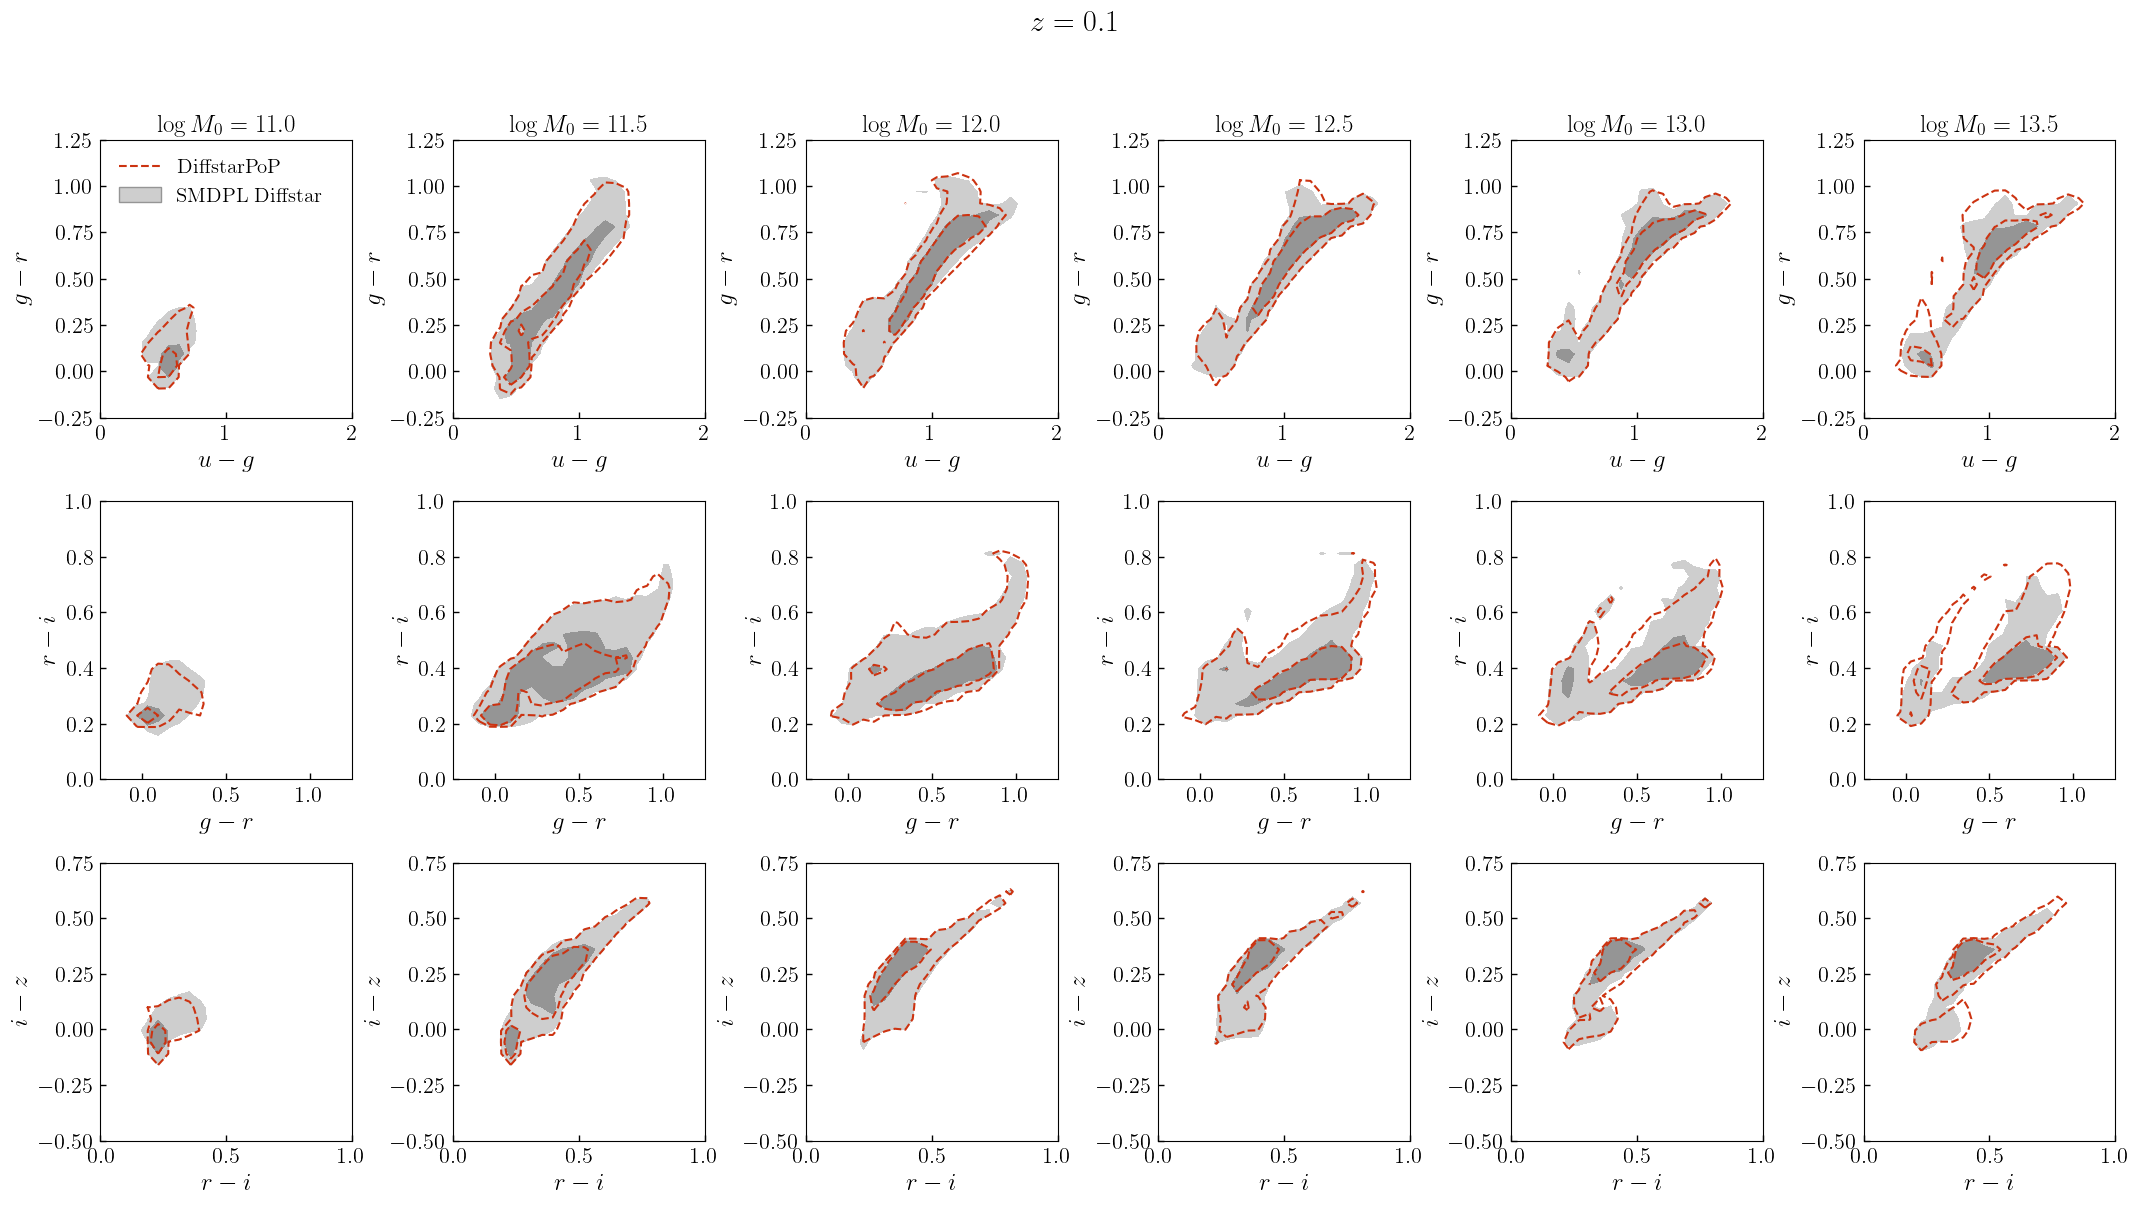

In [76]:
colors = ["#0077BB", "#33BBEE", "#009988", "#EE7733", "#CC3311", "#EE3377", '#882255', '#AA4499']
colors_test = plt.get_cmap("Greys")(np.linspace(0.3,0.7, 3))
mag_names = ["u", "g", "r", "i", "z"]

fig, ax = plt.subplots(3, 6, figsize=(26,13), sharex=False, sharey=False)

nbins_x = bins_color.copy()
nbins_y = bins_color.copy()

N = 25

# nbins_x = nbins_y = np.linspace(-0.25, 1.75, 25)
# ticks = np.arange(0, 1.6, 0.5)
smooth = False
zid = 0

nbins_arr = [
    [
        np.linspace(0.0, 2.0, N),
        np.linspace(-0.25, 1.25, N),
        np.linspace(0.0, 1.0, N),
        np.linspace(-0.5, 0.75, N),
    ],
    [
        np.linspace(-0.25, 1.25, N),
        np.linspace(0.0, 1.75, N),
        np.linspace(0.0, 1.25, N),
        np.linspace(-0.5, 0.75, N),
    ],
    [
        np.linspace(-0.5, 1.25, N),
        np.linspace(-0.5, 1.75, N),
        np.linspace(0.0, 1.25, N),
        np.linspace(-0.25, 1.25, N),
    ],
]
nbins_arr = nbins_arr[zid]

for j, bin_id in enumerate([1, 2, 3, 4, 5, 6]):
    for i in range(3):
        nbins_x = nbins_arr[i]
        nbins_y = nbins_arr[i+1]
        xdata = gal_mags_arr[bin_id][zid, :, i] - gal_mags_arr[bin_id][zid, :, i+1]
        ydata = gal_mags_arr[bin_id][zid, :, i+1] - gal_mags_arr[bin_id][zid, :, i+2]
        weights = weights_arr[bin_id]
        density_contour(xdata, ydata, nbins_x, nbins_y, ax=ax[i,j], smooth=smooth, weights=weights, linestyles=['--'], level=0.68, colors=[colors[4]])
        density_contour(xdata, ydata, nbins_x, nbins_y, ax=ax[i,j], smooth=smooth, weights=weights, linestyles=['--'], level=0.95, colors=[colors[4]])

        xdata = gal_mags_SMDPL_arr[bin_id][zid, :, i] - gal_mags_SMDPL_arr[bin_id][zid, :, i+1]
        ydata = gal_mags_SMDPL_arr[bin_id][zid, :, i+1] - gal_mags_SMDPL_arr[bin_id][zid, :, i+2]
        # density_contour(xdata, ydata, nbins_x, nbins_y, ax=ax[i,j], smooth=smooth, level=0.68, linestyles=['--'], colors=[colors[4]])
        # density_contour(xdata, ydata, nbins_x, nbins_y, ax=ax[i,j], smooth=smooth, level=0.95, linestyles=['--'], colors=[colors[4]])
        density_contourf(xdata, ydata, nbins_x, nbins_y, ax=ax[i,j], smooth=smooth, levels=[0.0, .68, 0.95], colors=colors_test)

        # break
        if i==0:
            ax[i,j].set_title(r"$\log M_0 = %.1f$"%logm0_binmids[j])
        # if (j>0):
        #     ax[i,j].set_yticks([])
        # ax[i,j].set_xticks(ticks)
        # ax[i,j].set_yticks(ticks)
        ax[i,j].set_xlabel(r"$%s-%s$"%(mag_names[i], mag_names[i+1]))
        ax[i,j].set_ylabel(r"$%s-%s$"%(mag_names[i+1], mag_names[i+2]))
        ax[i,j].set_xlim(nbins_x[0], nbins_x[-1])
        ax[i,j].set_ylim(nbins_y[0], nbins_y[-1])
            
            
            
legend_elements = [
    Line2D([0], [0], color=colors[4], ls='--', label=r'DiffstarPoP'),
    Patch(facecolor=colors_test[0], edgecolor=colors_test[1], label=r'SMDPL Diffstar')
]
ax[0,0].legend(handles=legend_elements, loc=2)

fig.suptitle(r"$z=%.1f$"%z_arr[zid])
fig.subplots_adjust(wspace=0.4, hspace=0.3)
#fig.savefig("color_color_plot_diffstarpop_smdpl_z%.2f_v3.png"%z_arr[zid], bbox_inches="tight", dpi=300)


In [42]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])


In [58]:
path_json = "/Users/alarcon/Documents/source/diffstarpop/diffstarpop/bestfit_diffstarpop_params_UM_hists_v4.json"
outputs = load_params(path_json)


In [79]:
#t_table = np.linspace(1.0, TODAY, 1000)
#lgt = jnp.log10(t_table)

n_histories = int(5e4)
ran_key = jran.PRNGKey(0)

gal_mags_arr = []
gal_mags_SMDPL_arr = []
weights_arr = []
# for i, bin_id in enumerate(range(len(logm0_binmids))):
bin_id = 3
t0 = time.time()

t_table = np.linspace(1.0, TODAY, 1000)
lgt = jnp.log10(t_table)
z_table = np.array([z_at_value(Planck13.age, x * u.Gyr, zmin=-1) for x in t_table])

_mask = (logmpeak > logm0_binmids[bin_id] - logm0_bin_widths[bin_id]) 
_mask &= (logmpeak < logm0_binmids[bin_id] + logm0_bin_widths[bin_id])
_mask = np.random.choice(np.arange(len(logmpeak))[_mask], n_histories, replace=True)

#_sel = (logmpeak > logm0_binmids[i] - logm0_bin_widths[i]) & (logmpeak < logm0_binmids[i] + logm0_bin_widths[i])
#_sel &= normal_values
#print(_sel.sum())
#sel = np.random.choice(np.arange(len(p50_arr))[_sel], Nhalos, replace=True)
_halo_data_MC = mah_params_arr[_mask]
_p50 = p50_arr[_mask]

histories = draw_sfh_MIX(
    t_table,
    logm0_binmids[bin_id],
    _halo_data_MC[:, np.array([1,2,4,5])],
    _p50,
    n_histories,
    ran_key,
    index_select,
    index_high,
    fstar_tdelay,
    #init_guess[0:N_PDF_Q],
    #init_guess[N_PDF_Q:N_PDF_Q+N_PDF_MS],
    #init_guess[N_PDF_Q+N_PDF_MS:N_PDF_Q+N_PDF_MS+N_R_Q],
    #init_guess[N_PDF_Q+N_PDF_MS+N_R_Q:N_PDF_Q+N_PDF_MS+N_R_Q+N_R_MS],
    outputs[0][0:N_PDF_Q],
    outputs[0][N_PDF_Q:N_PDF_Q+N_PDF_MS],
    outputs[0][N_PDF_Q+N_PDF_MS:N_PDF_Q+N_PDF_MS+N_R_Q],
    outputs[0][N_PDF_Q+N_PDF_MS+N_R_Q:N_PDF_Q+N_PDF_MS+N_R_Q+N_R_MS],
)


weights = histories[4].copy()
_params = np.zeros((Nhalos, 6))
_params[:, 0] = np.log10(TODAY)
_params[:, 1:3] = halo_data_MC.reshape(len(logm0_binmids),Nhalos,4)[bin_id][:, 0:2]
_params[:, 3] = 3.5
_params[:, 4:6] = halo_data_MC.reshape(len(logm0_binmids),Nhalos,4)[bin_id][:, 2:4]

mah_histories = _calc_halo_history_vmap(lgt, *_params.T)



mah_histories_SMDPL = _calc_halo_history_vmap(lgt, *mah_params_arr[_mask].T)

histories_SMDPL = sm_sfr_history_diffstar_scan_XsfhXmah_vmap(
    t_table,
    jnp.log10(t_table),
    _get_dt_array(t_table),
    mah_params_arr[_mask][:, np.array([1,2,4,5])],
    u_fit_params_arr[_mask][:,np.array([0,1,2,4])],
    u_fit_params_arr[_mask][:,5:9],
    index_select,
    index_high,
    fstar_tdelay,
)


t1 = time.time()
print("time i", t1-t0)


time i 126.42430686950684


[2.9947026]


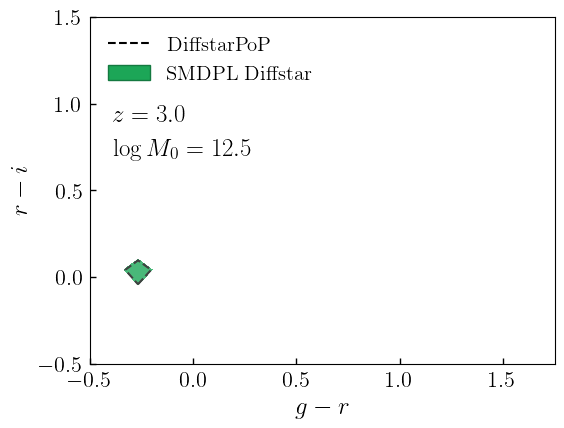

[2.96298494]


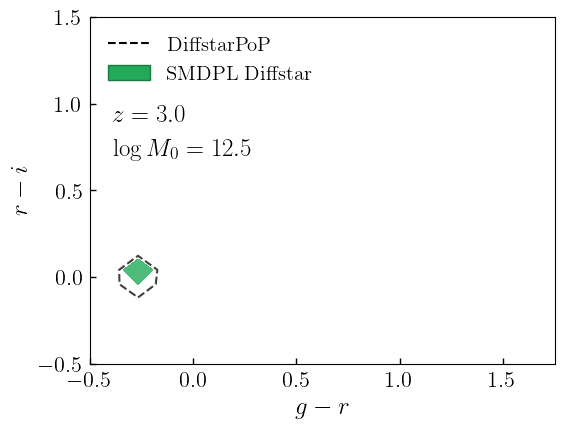

[2.94735587]


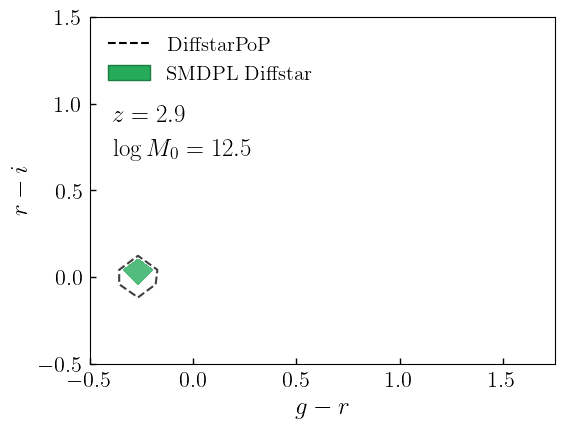

[2.91654547]


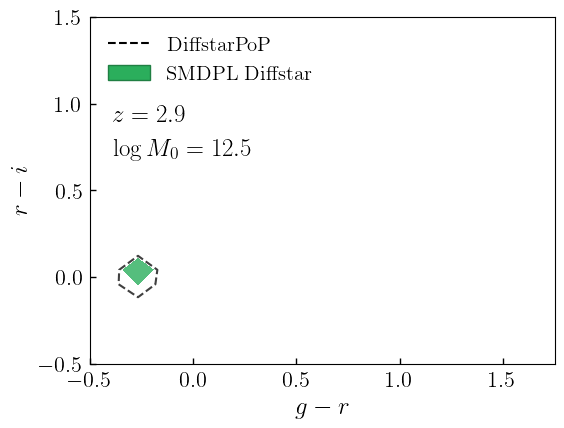

[2.88631691]


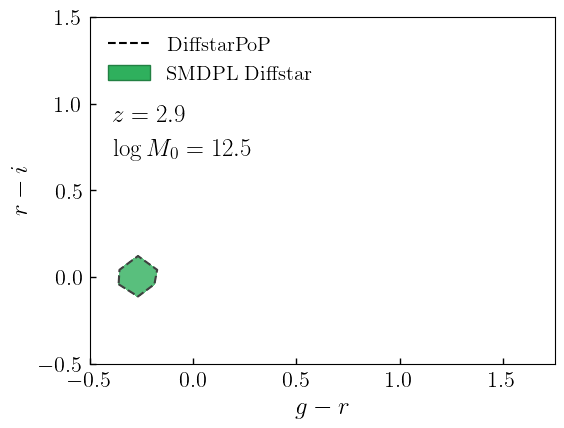

[2.85665258]


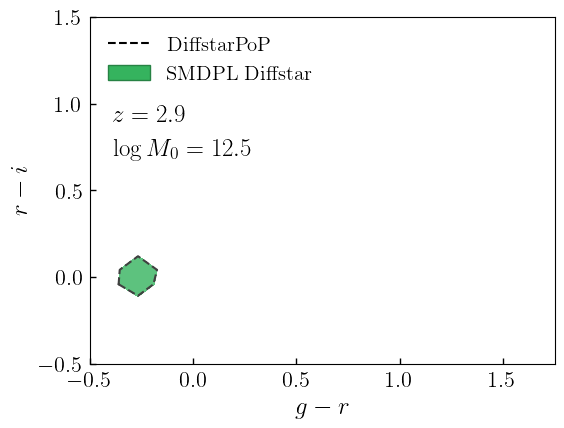

[2.82753563]


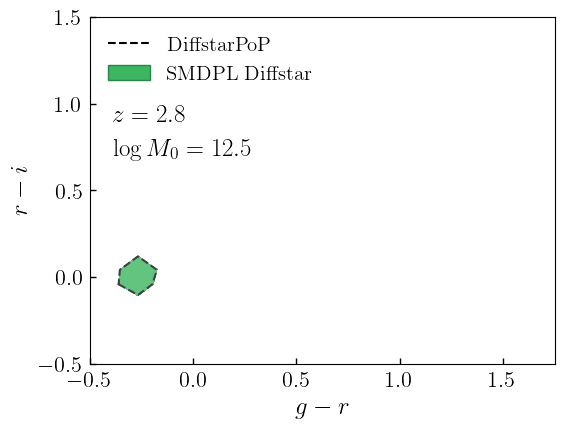

[2.79894993]


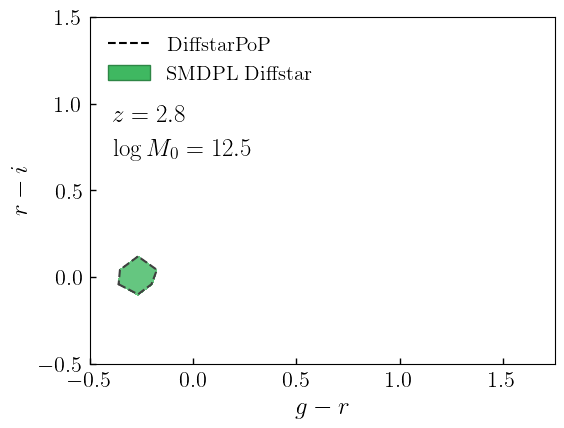

[2.77087992]


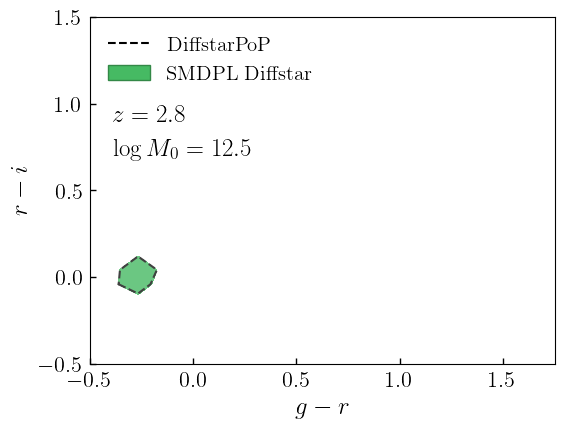

[2.72970944]


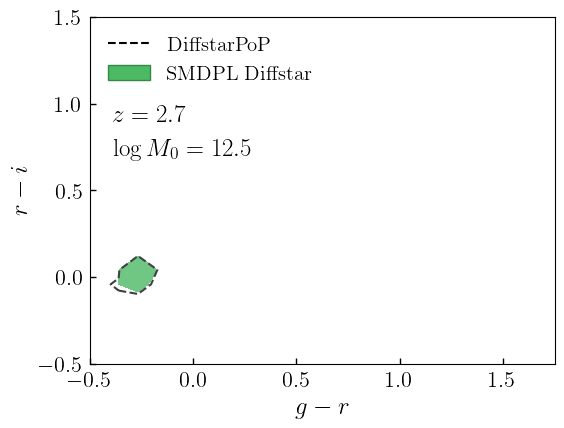

[2.7028648]


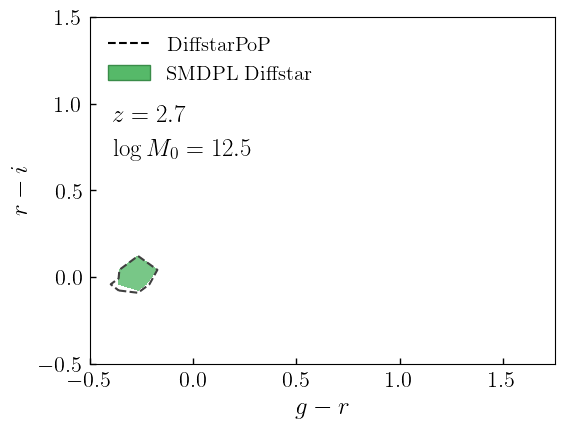

[2.67648624]


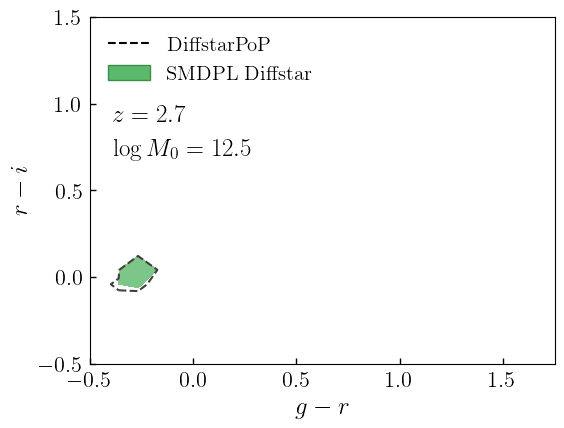

[2.65056077]


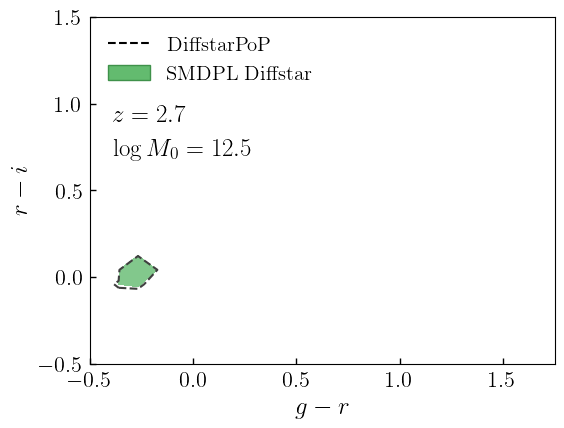

[2.6250759]


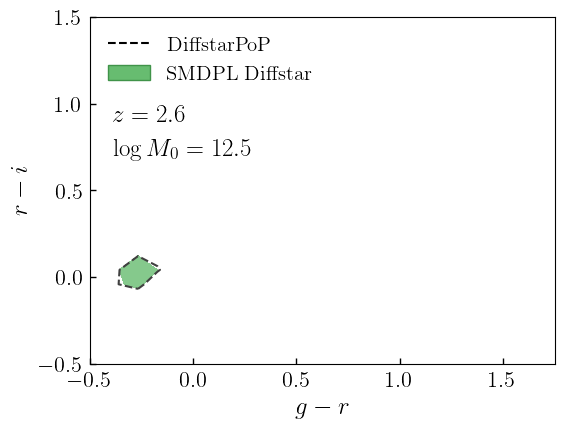

[2.58764857]


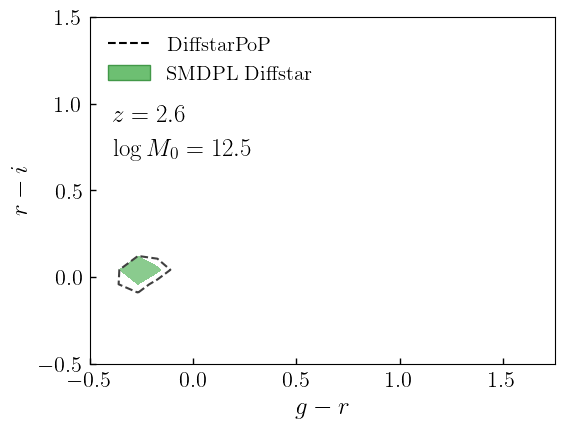

[2.56321365]


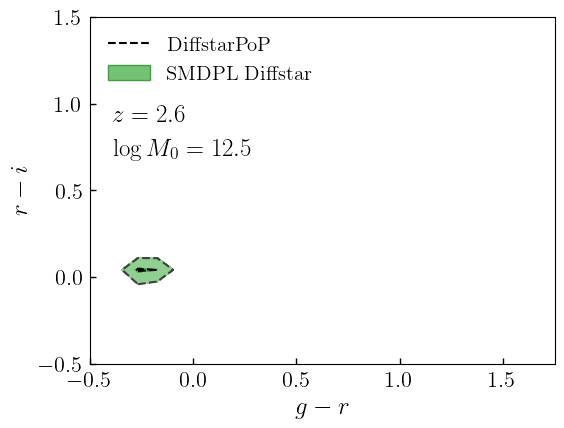

[2.52730878]


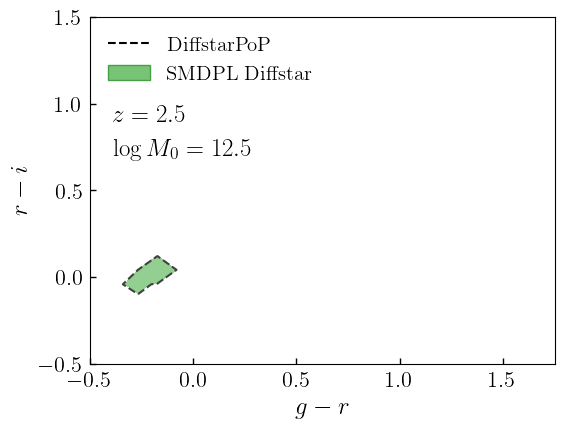

[2.50385533]


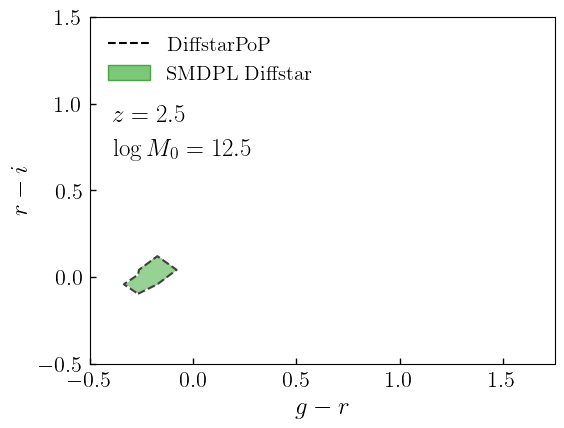

[2.4693749]


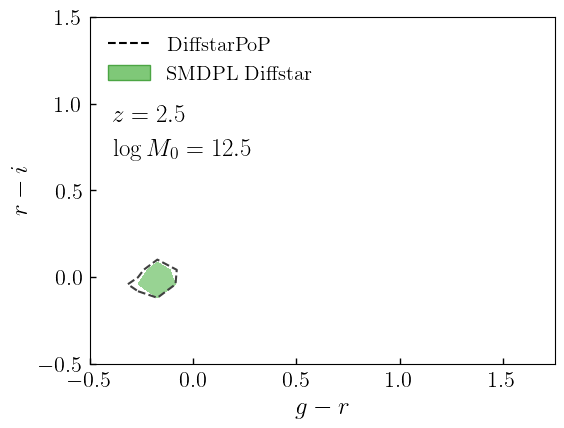

[2.4468405]


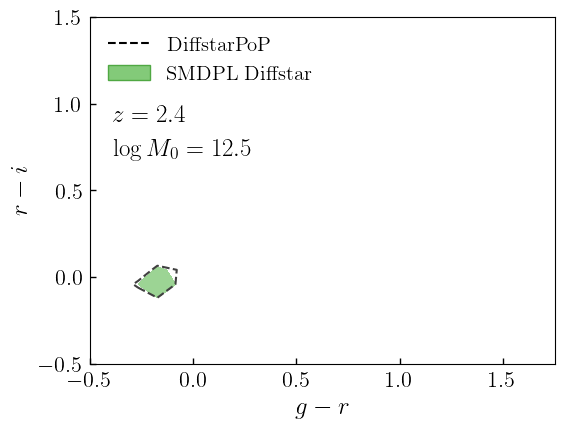

[2.41369492]


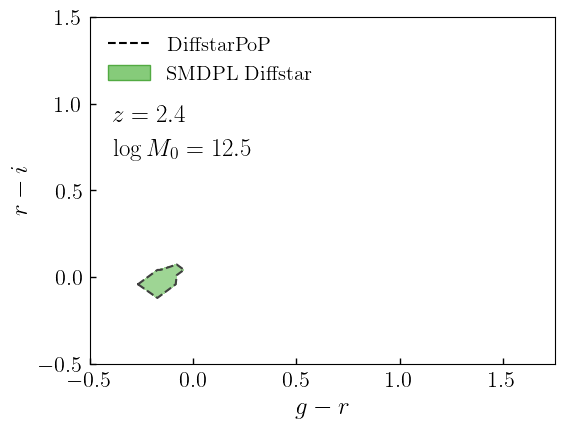

[2.38131046]


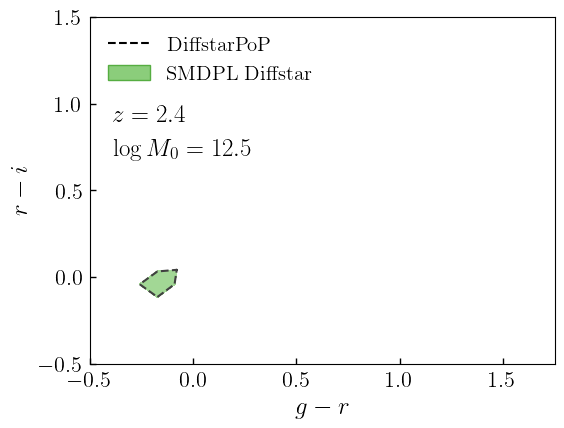

[2.36012975]


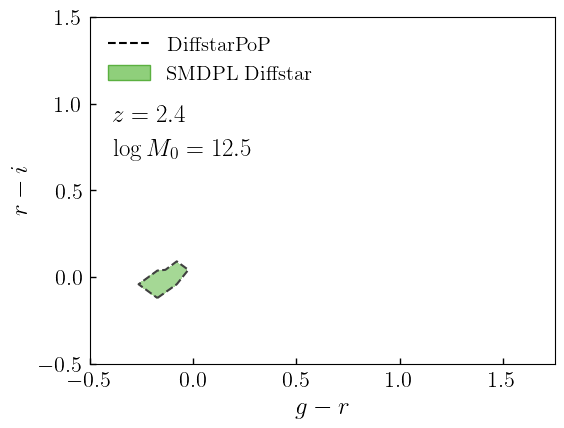

[2.32895223]


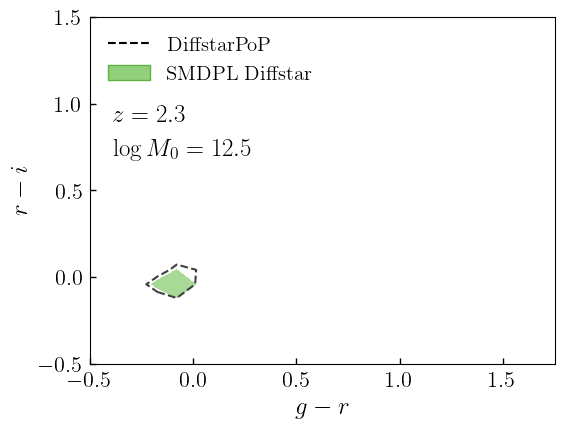

[2.29846415]


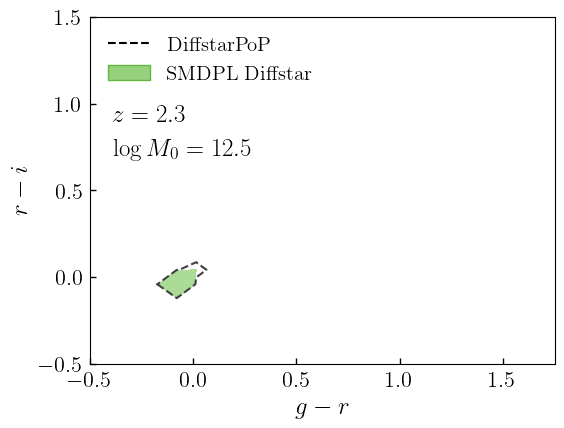

[2.26864105]


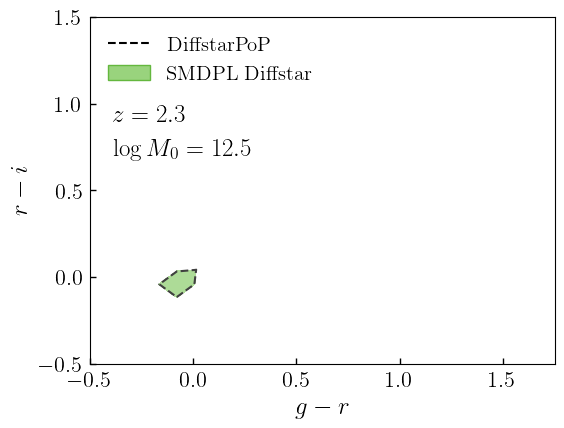

[2.23945963]


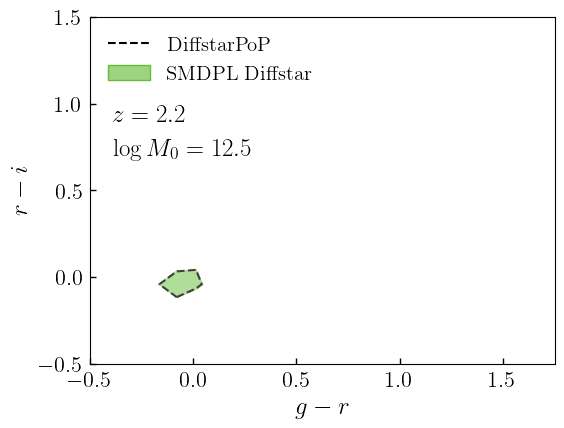

[2.21089767]


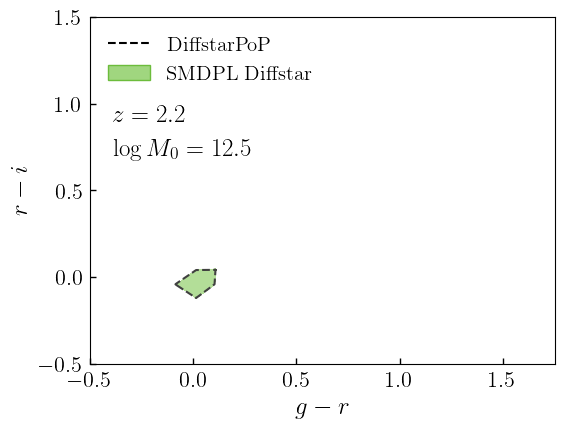

[2.18293407]


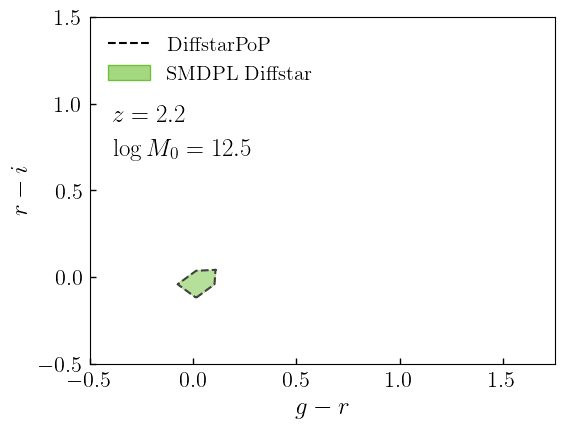

[2.14654522]


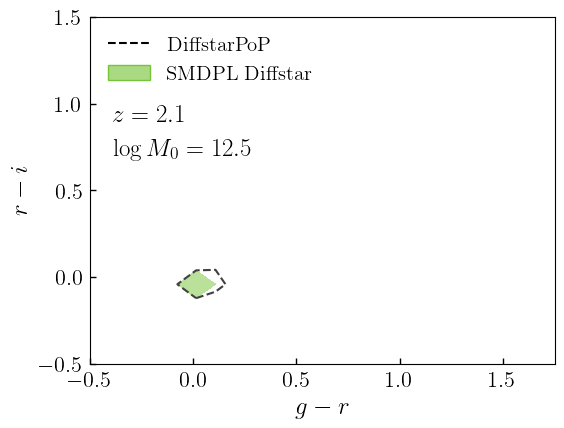

[2.11990081]


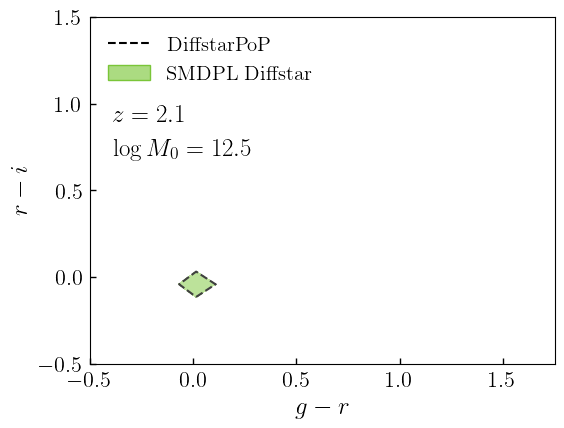

[2.09379099]


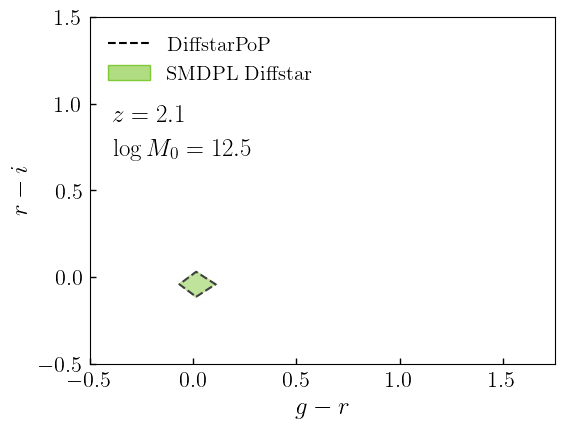

[2.05977964]


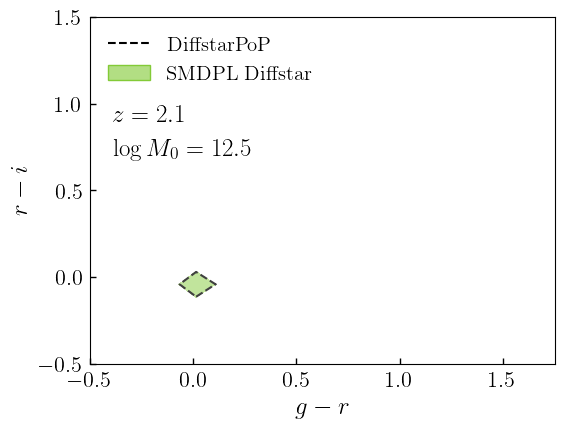

[2.03485118]


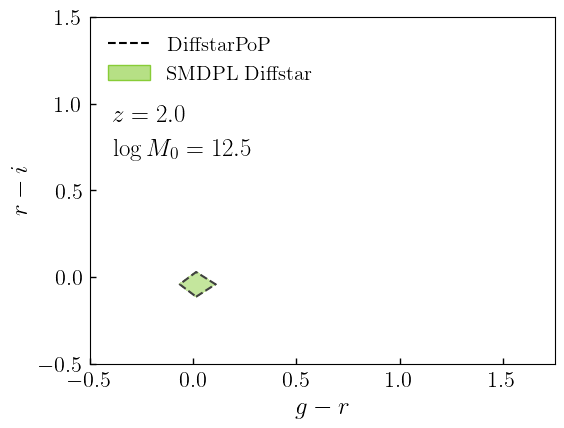

[2.00235697]


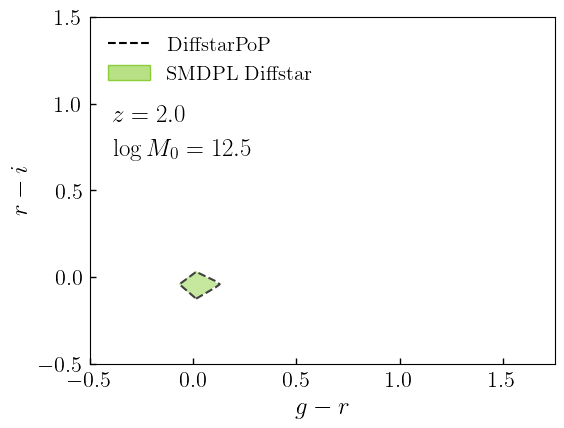

[1.97852491]


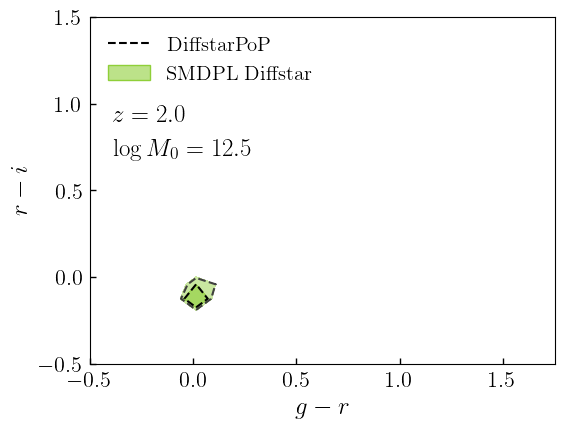

[1.94744015]


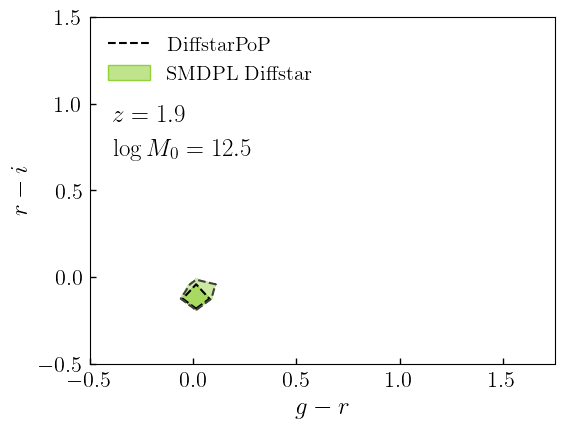

[1.91711646]


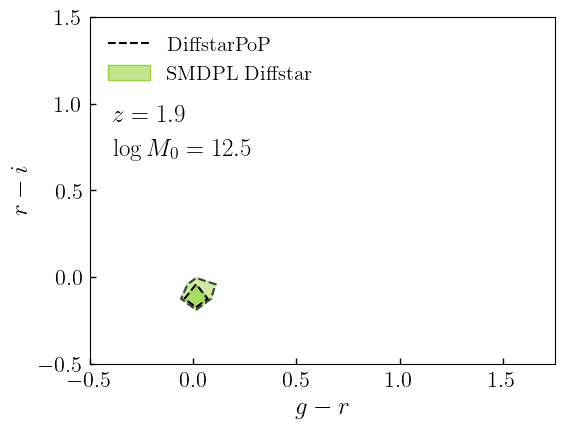

[1.88752376]


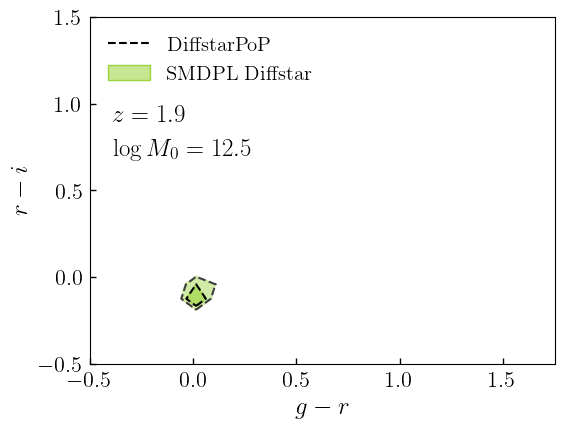

[1.85863354]


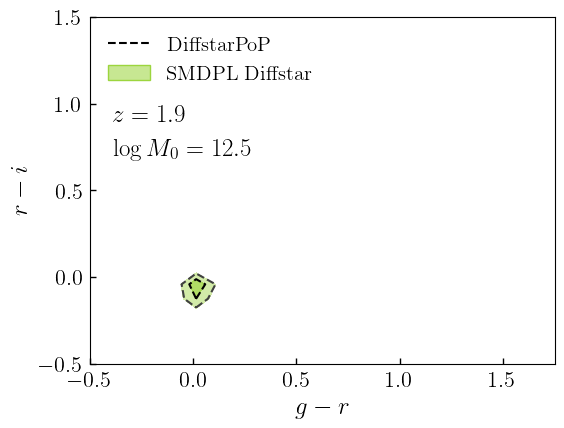

[1.83041889]


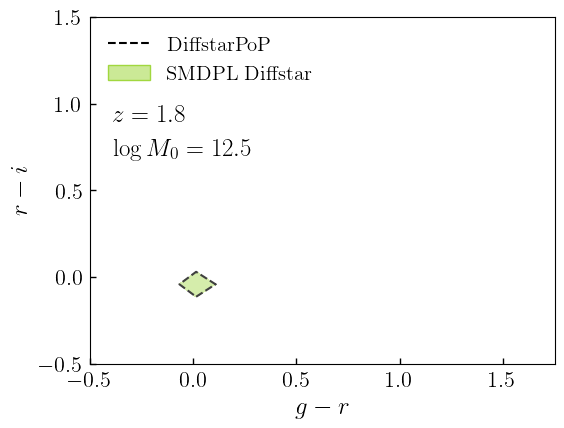

[1.79606174]


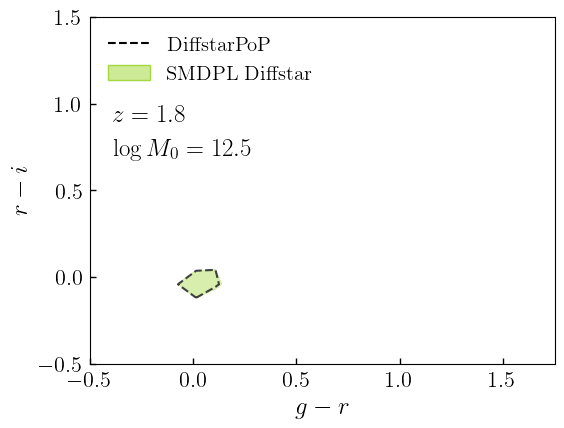

[1.76927559]


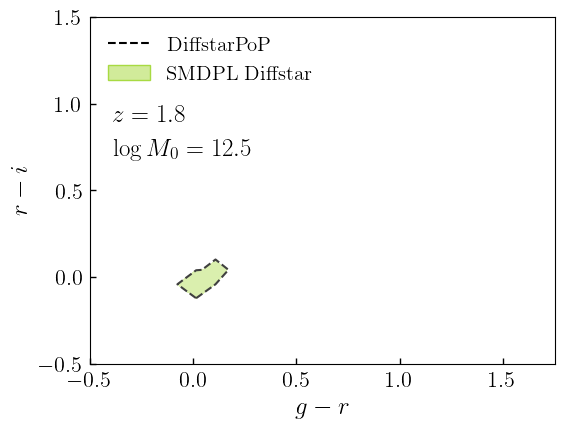

[1.74308658]


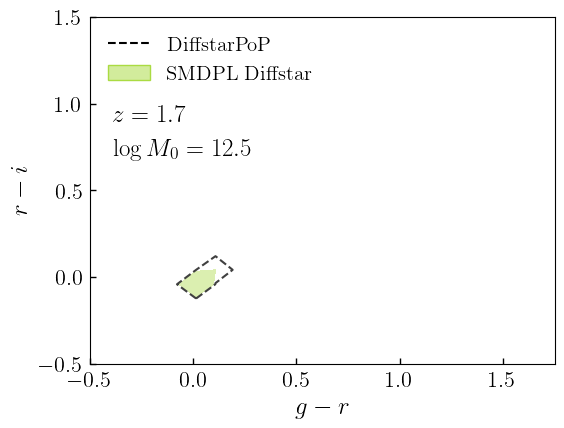

[1.71115723]


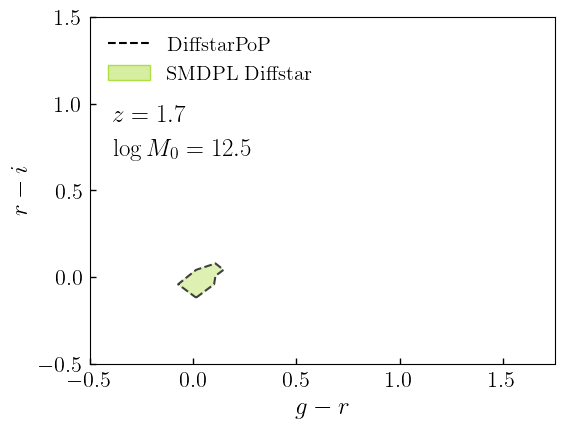

[1.68008732]


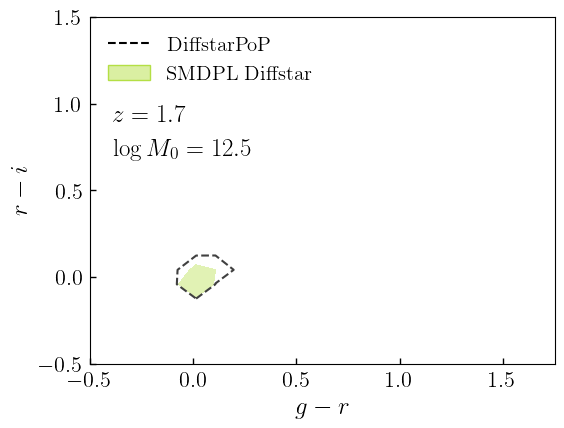

[1.64983936]


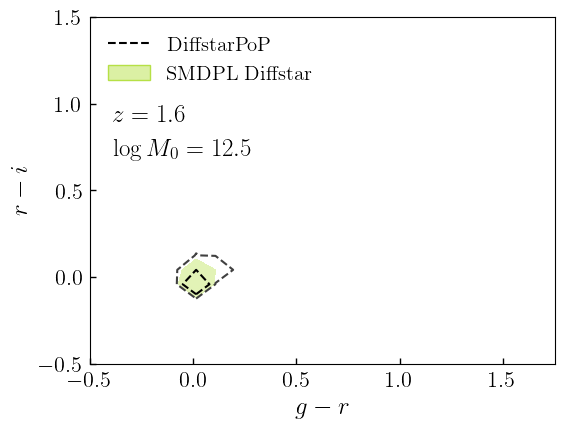

[1.62037806]


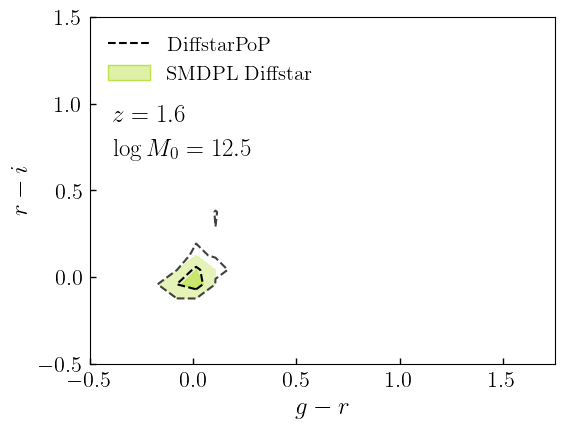

[1.59167021]


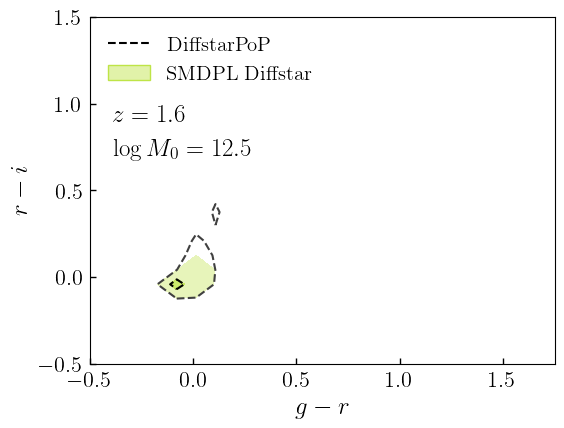

[1.56368445]


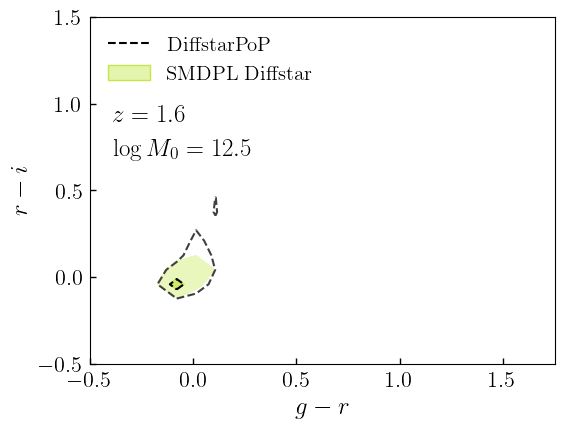

[1.5363912]


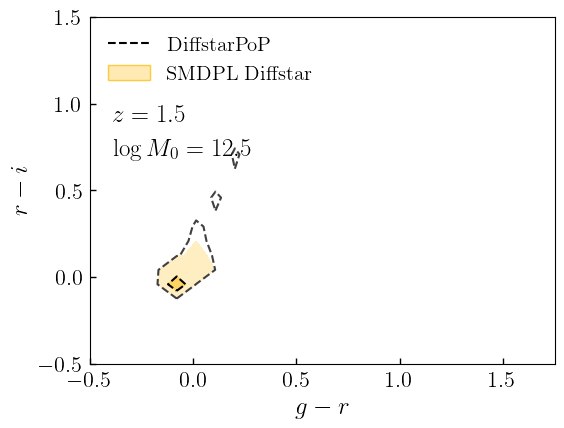

[1.50451417]


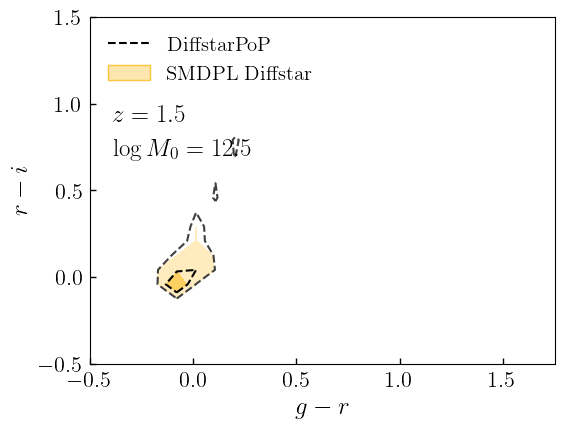

[1.47864823]


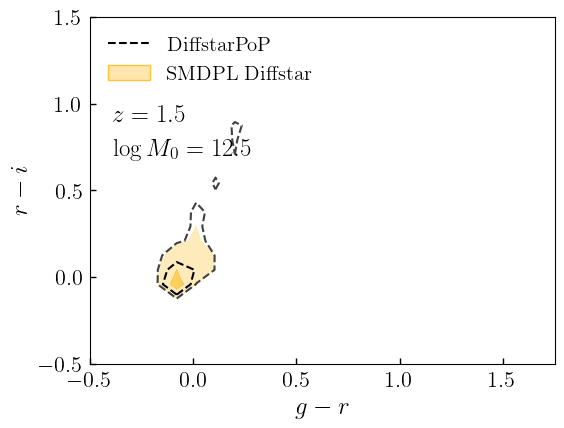

[1.44841001]


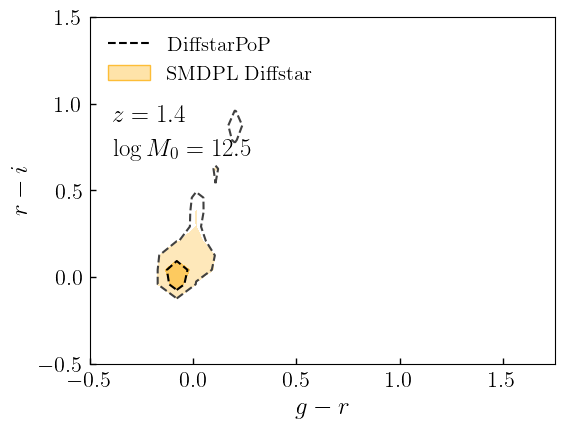

[1.41900762]


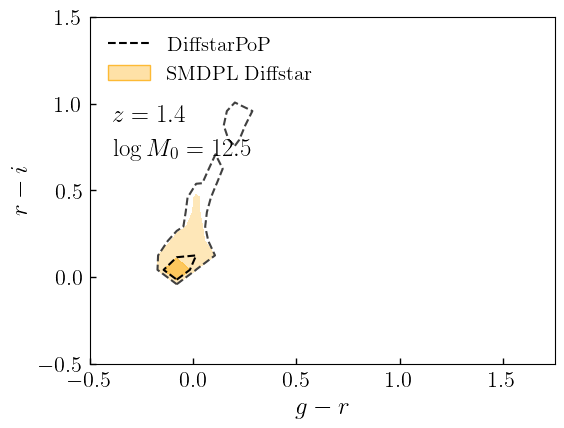

[1.39040326]


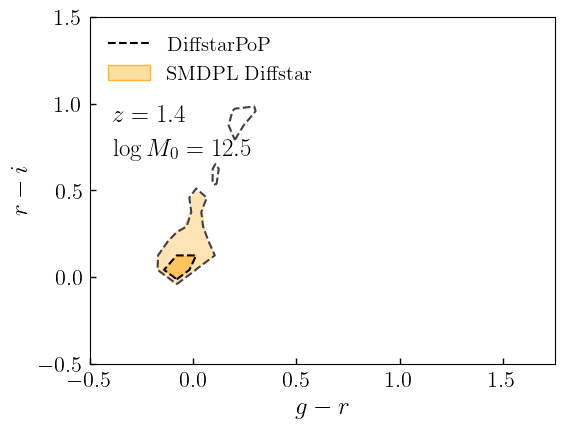

[1.35799299]


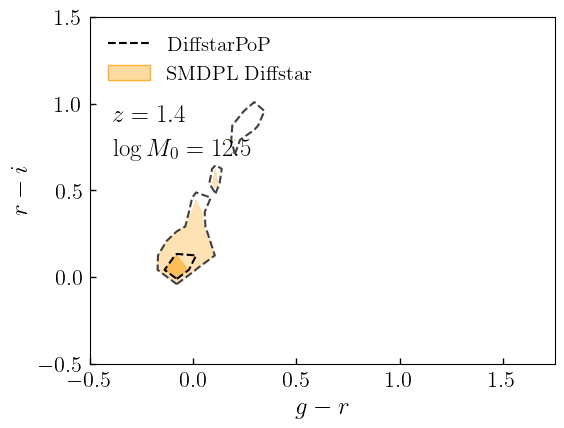

[1.330999]


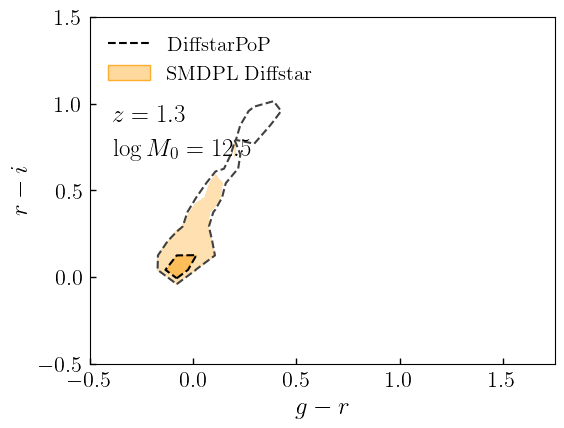

[1.30037962]


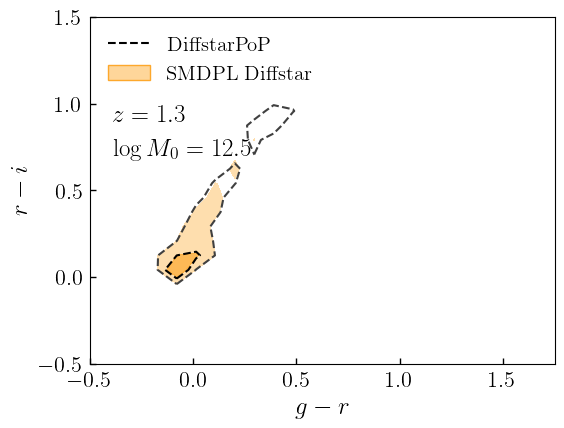

[1.27065721]


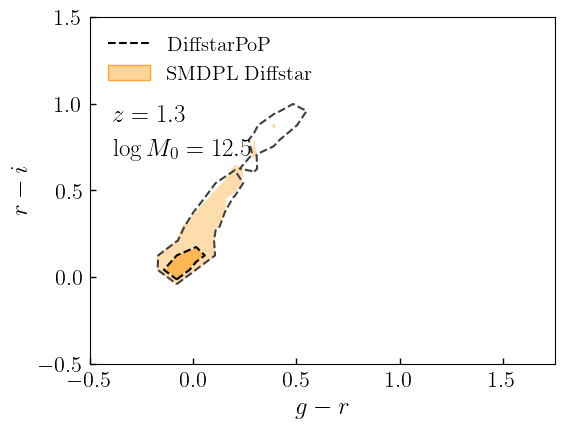

[1.24178859]


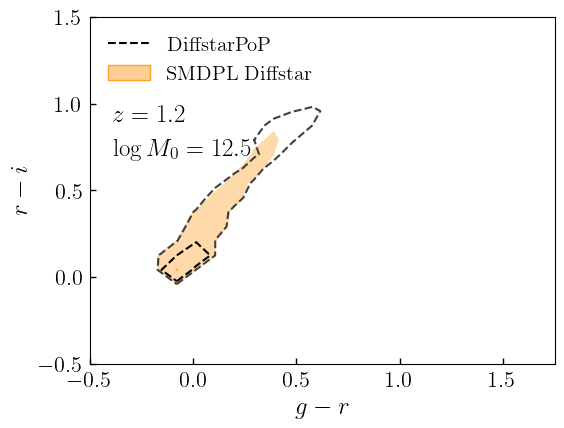

[1.21373339]


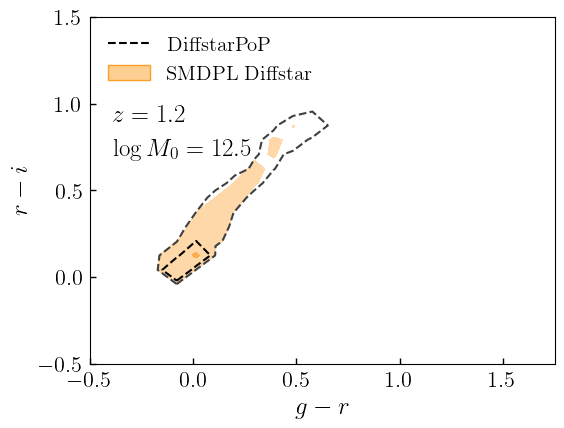

[1.18261801]


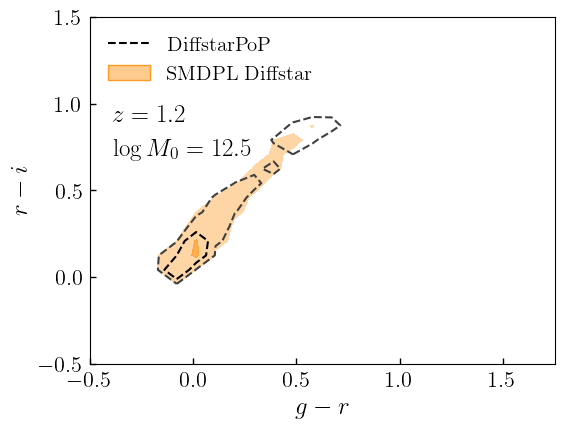

[1.15618169]


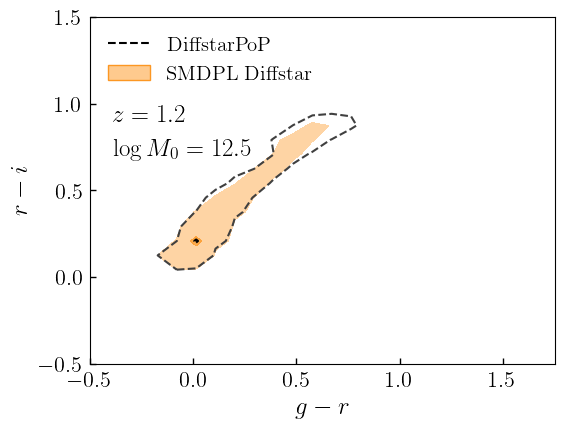

[1.12682706]


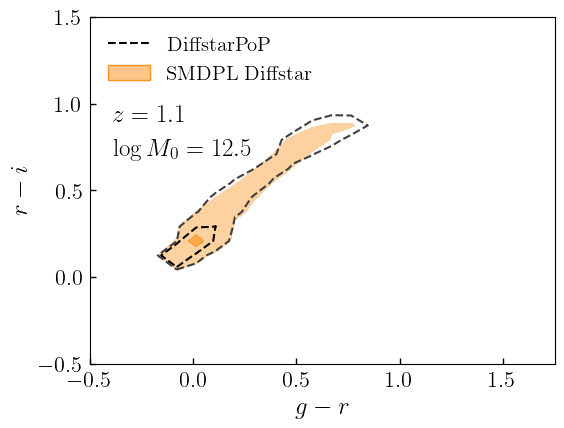

[1.09484272]


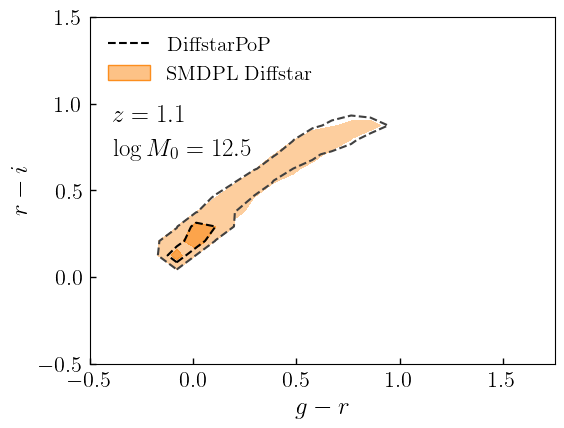

[1.06728904]


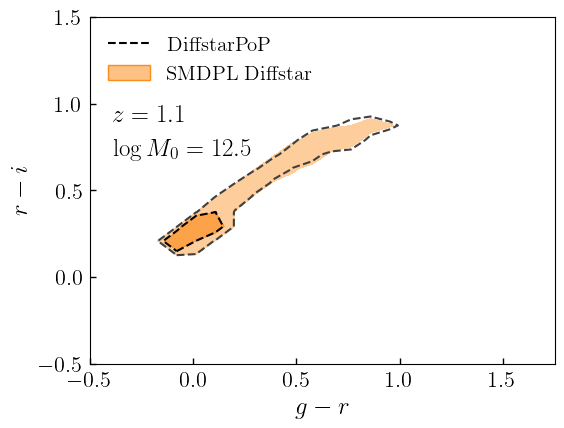

[1.03722621]


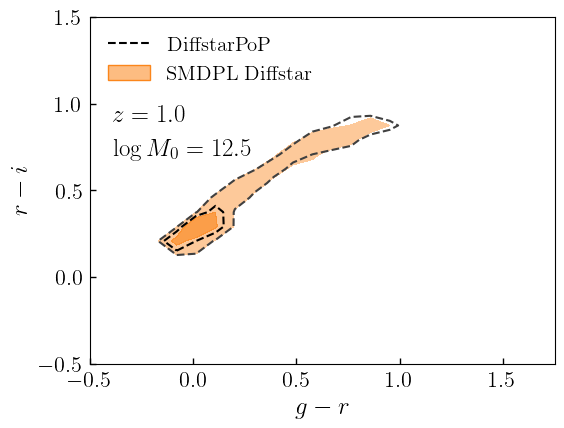

[1.0081029]


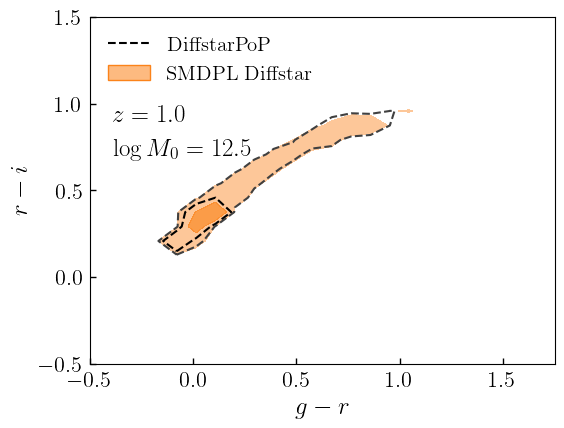

[0.97987026]


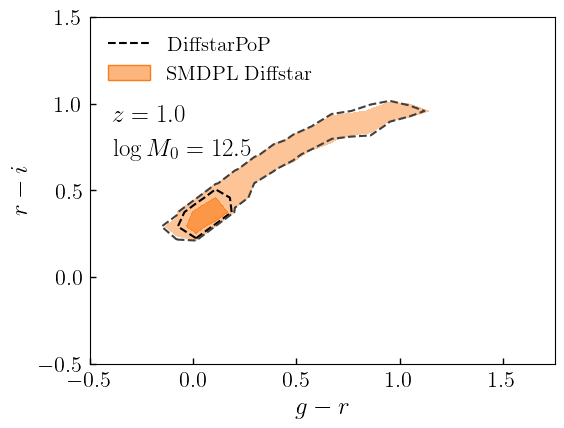

[0.94949011]


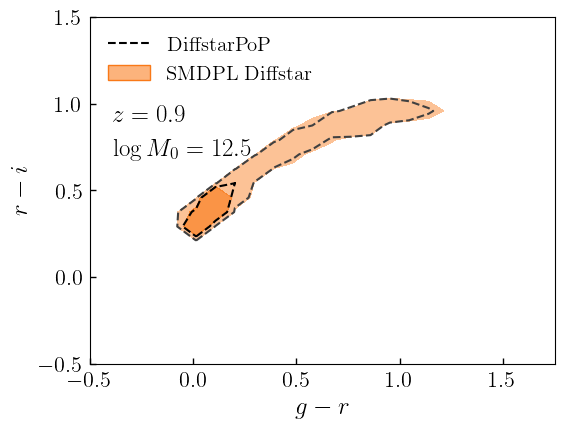

[0.92009575]


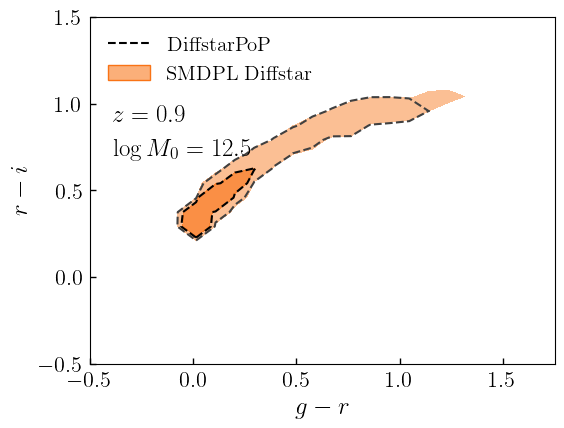

[0.89163368]


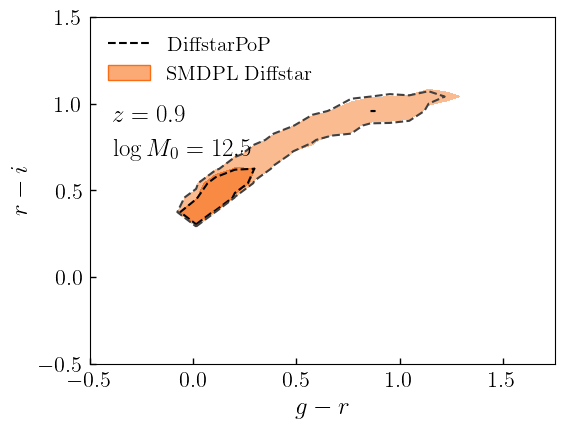

[0.86134319]


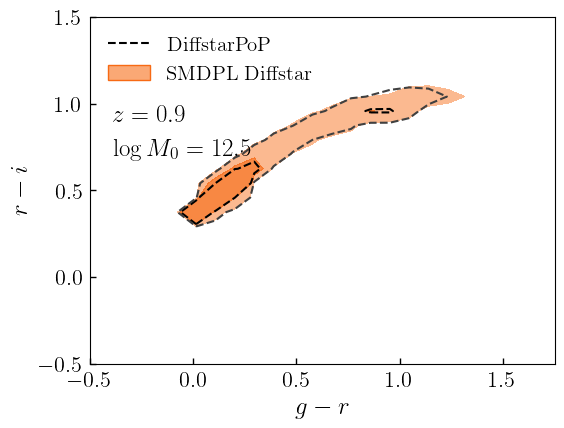

[0.83205988]


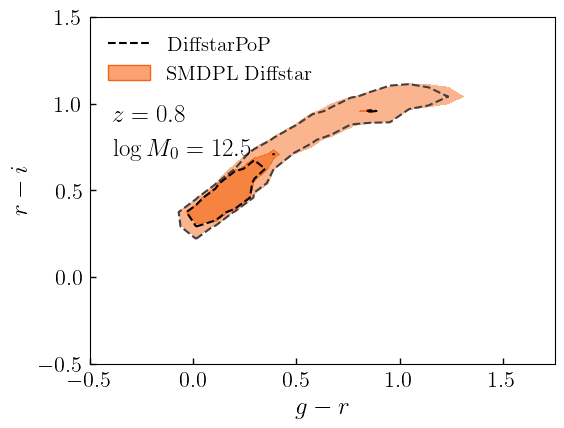

[0.80372745]


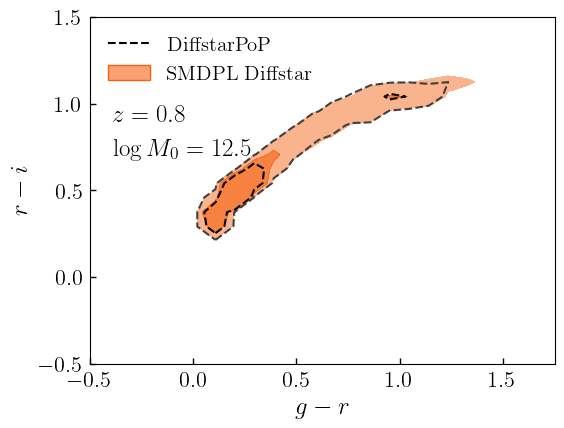

[0.77384275]


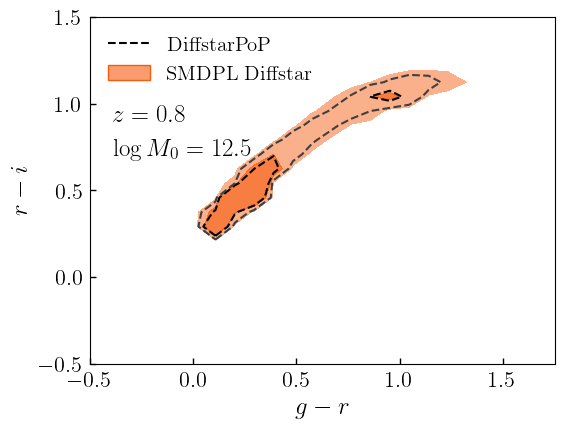

[0.74496543]


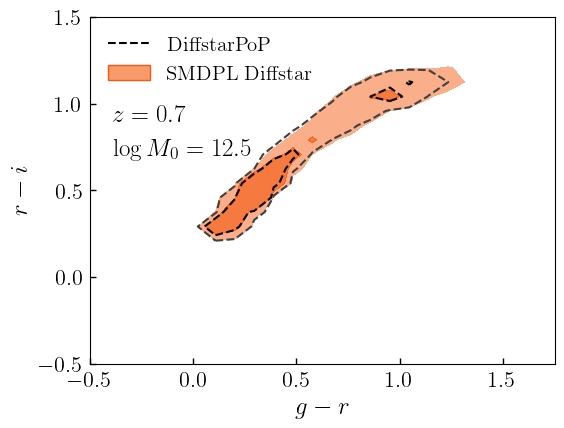

[0.71475194]


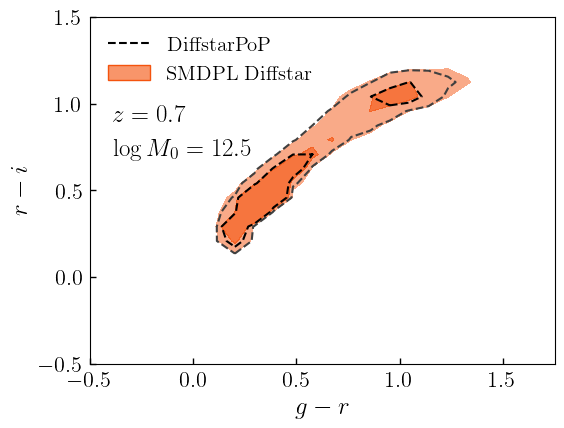

[0.68558618]


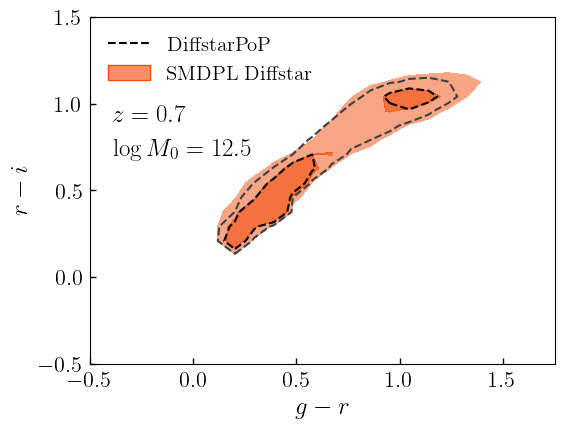

[0.65740643]


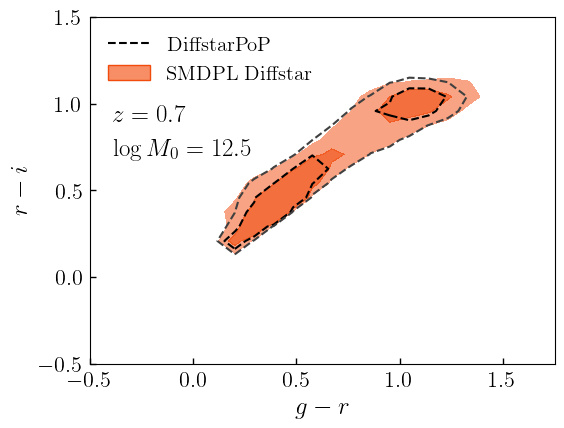

[0.62809666]


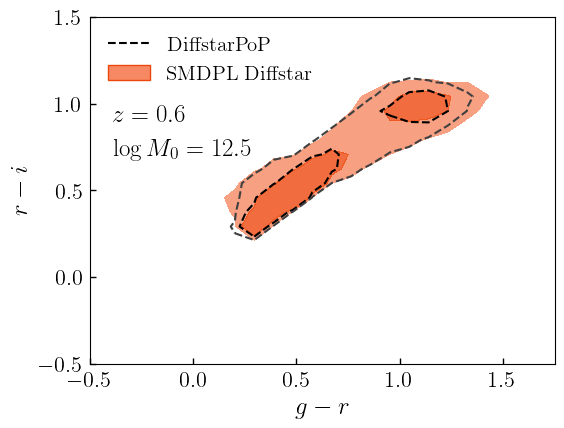

[0.59781535]


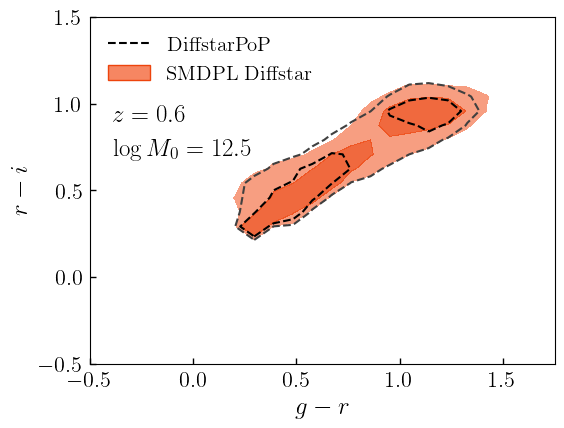

[0.56862308]


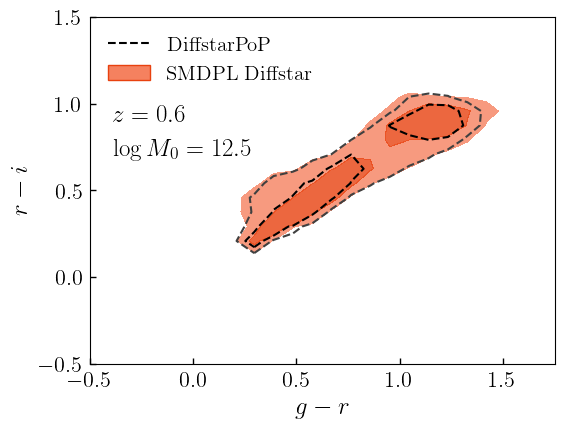

[0.53860954]


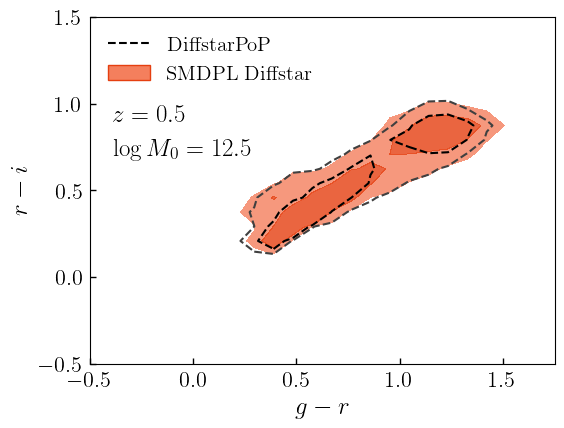

[0.50968441]


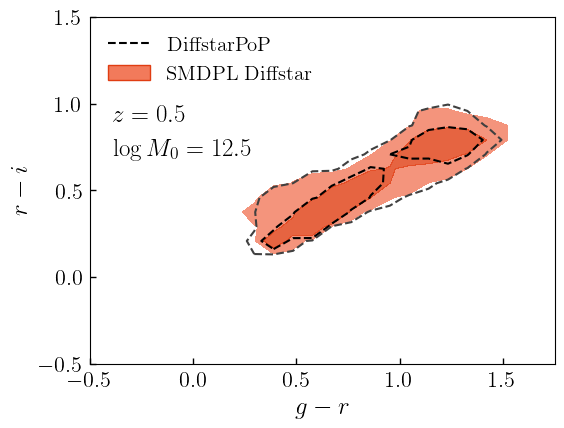

[0.48006815]


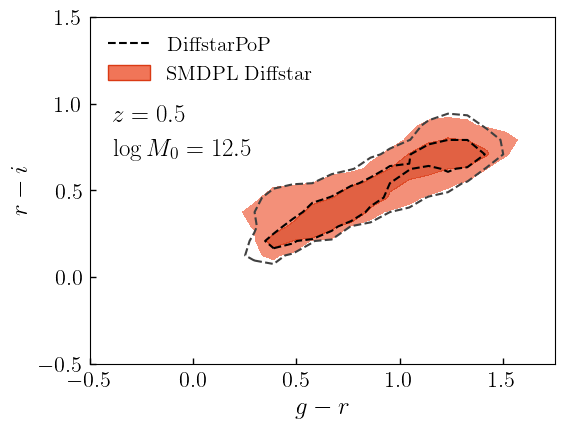

[0.45152964]


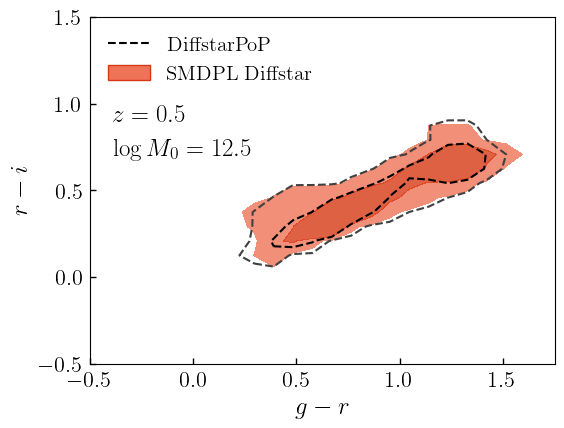

[0.42241184]


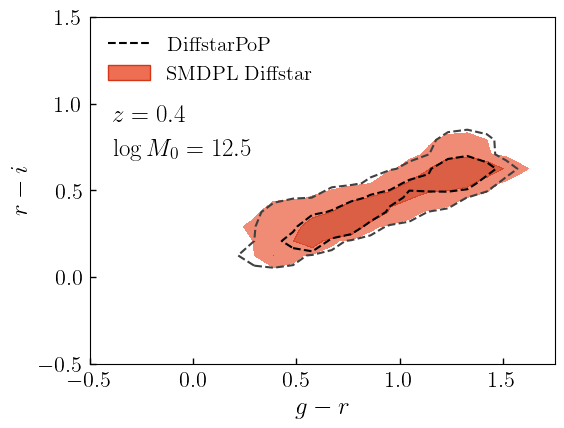

[0.39282386]


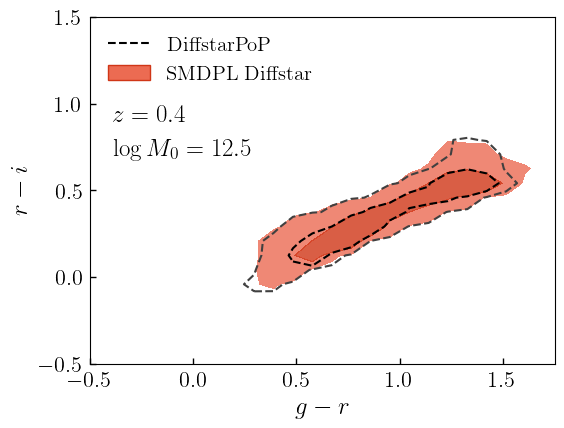

[0.3643374]


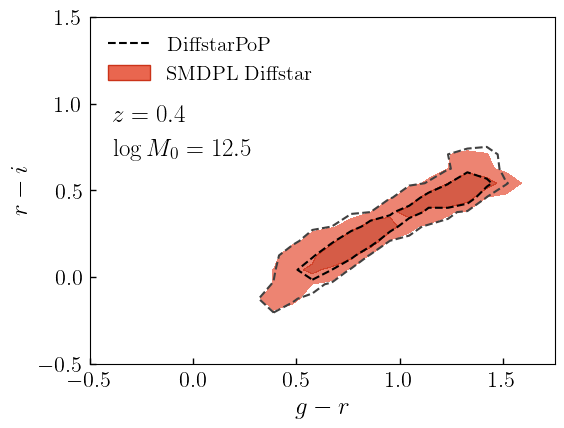

[0.3340483]


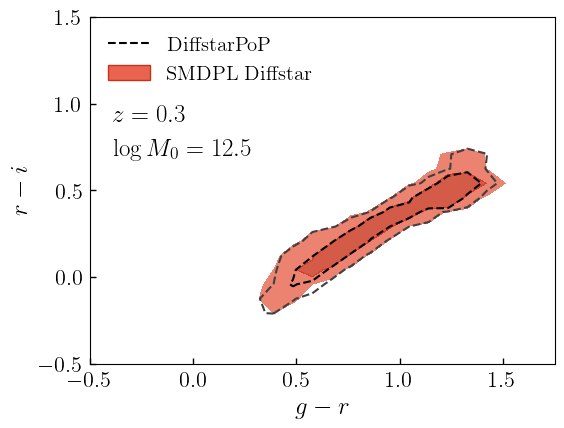

[0.30493065]


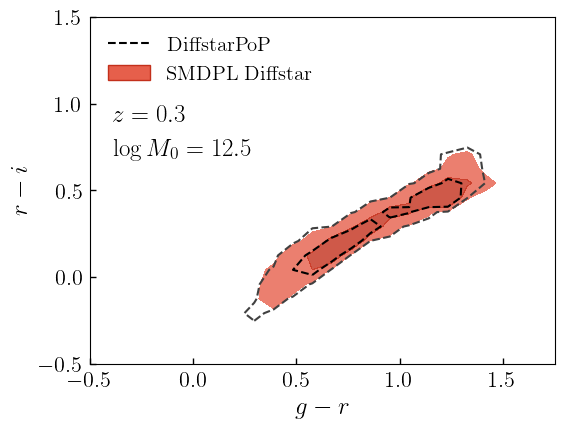

[0.27559702]


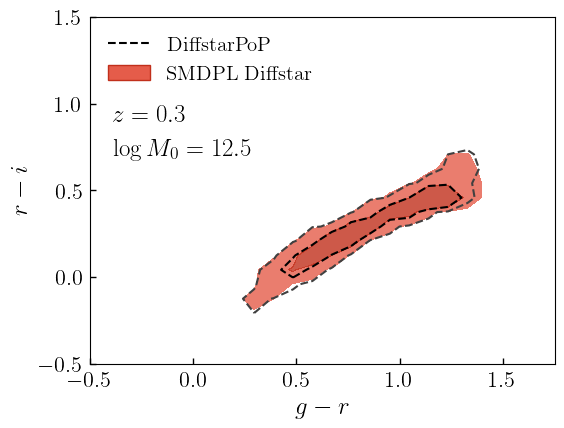

[0.24612321]


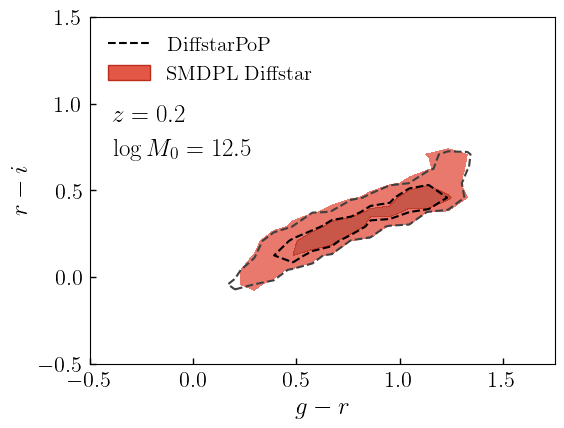

[0.21657821]


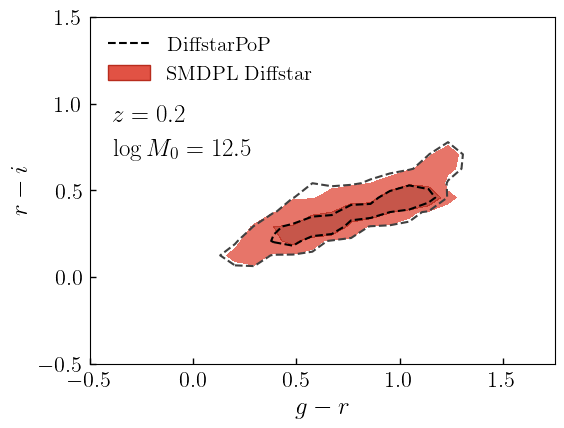

[0.18818381]


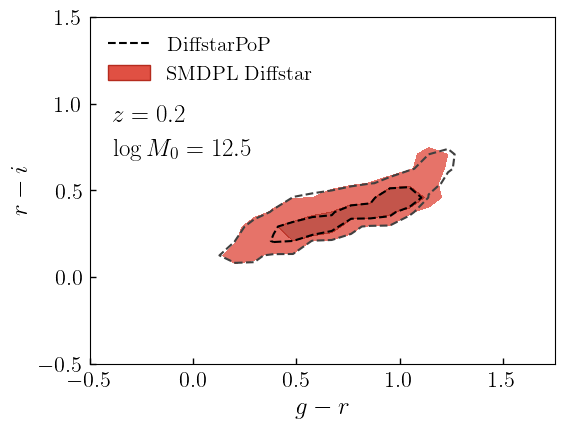

[0.15863109]


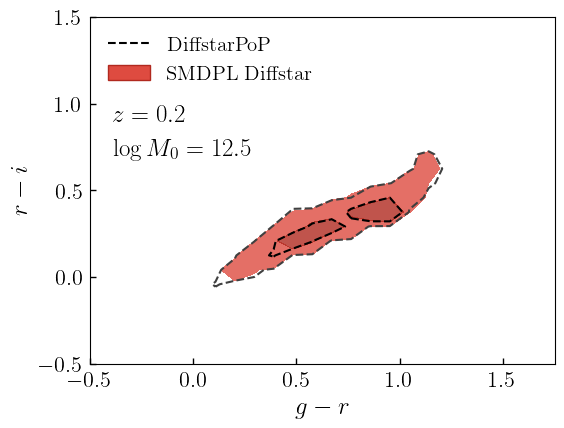

[0.12917802]


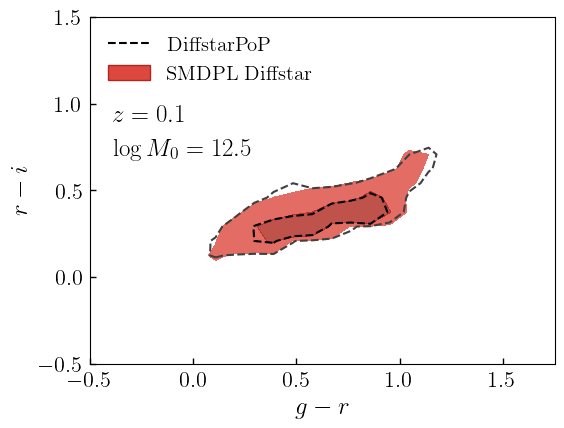

[0.09986961]


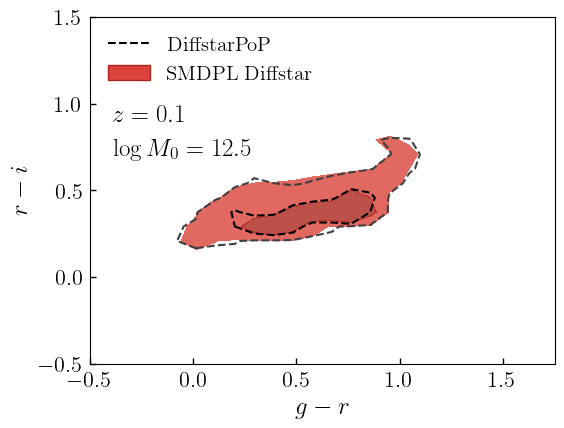

In [88]:
colors_greys = plt.get_cmap("Greys")(np.array([0.8, 1.0]))

_bla = np.concatenate((
    np.linspace(0.1, 2.0, 90),
    np.linspace(2.0, 3.0, 11)[1:]
))

_bla = np.linspace(0.1, 3.0, 100)
_ids = np.argmin(np.subtract.outer(z_table, _bla)**2, axis=0)[::-1]
#_ids = np.argmin(np.subtract.outer(z_table, np.linspace(0.1, 3.0, 6))**2, axis=0)[::-1]

nbins_x = np.linspace(-0.5, 1.75, 25)
nbins_y = np.linspace(-0.5, 1.5, 25)

for j, t_id in enumerate(_ids):
    _fact = 1.5
    fig, ax = plt.subplots(1, 1, figsize=(4*_fact,3*_fact))    
    z_arr = np.atleast_1d(z_table[t_id])
    print(z_arr)
    ssp_obs_photflux_table_arr, dsps_data = precompute_DSPS_data(z_arr)
    gal_mags = get_colors(t_table, histories[1], z_arr, ssp_obs_photflux_table_arr, dsps_data, ran_key)
    gal_mags_SMDPL = get_colors(t_table, histories_SMDPL[1], z_arr, ssp_obs_photflux_table_arr, dsps_data, ran_key)

    xdata = gal_mags[0][:, 1] - gal_mags[0][:, 2]
    ydata = gal_mags[0][:, 2] - gal_mags[0][:, 3]
    density_contour(xdata, ydata, nbins_x, nbins_y, ax=ax, smooth=smooth, weights=weights, linestyles=['--'], level=0.68, colors=[colors_greys[1]])
    density_contour(xdata, ydata, nbins_x, nbins_y, ax=ax, smooth=smooth, weights=weights, linestyles=['--'], level=0.95, colors=[colors_greys[0]])

    xdata = gal_mags_SMDPL[0][:, 1] - gal_mags_SMDPL[0][:, 2]
    ydata = gal_mags_SMDPL[0][:, 2] - gal_mags_SMDPL[0][:, 3]
    # density_contour(xdata, ydata, nbins_x, nbins_y, ax=ax, smooth=smooth, level=0.68, linestyles=['--'], colors=[colors[4]])
    # density_contour(xdata, ydata, nbins_x, nbins_y, ax=ax, smooth=smooth, level=0.95, linestyles=['--'], colors=[colors[4]])
    colors_ = np.concatenate((
        np.array(plt.get_cmap("RdYlGn")(np.linspace(0.1,0.4, int(len(_ids)/2)))),
        np.array(plt.get_cmap("RdYlGn")(np.linspace(0.6, 0.9, int(len(_ids)/2)))),
    ))[::-1]
    colors_ = [
        adjust_lightness(colors_[j], amount=1.1),
        adjust_lightness(colors_[j], amount=0.8),
        # colors_[j],
    ]
    density_contourf(xdata, ydata, nbins_x, nbins_y, ax=ax, smooth=smooth, levels=[0.0, .68, 0.95], colors=colors_, alpha=0.8)

    legend_elements = [
        Line2D([0], [0], color='k', ls='--', label=r'DiffstarPoP'),
        Patch(facecolor=colors_[0], edgecolor=colors_[1], label=r'SMDPL Diffstar')
    ]
    ax.set_xlabel(r"$g-r$")
    ax.set_ylabel(r"$r-i$")
    xlims = ax.set_xlim(nbins_x[0], nbins_x[-1])
    ylims = ax.set_ylim(nbins_y[0], nbins_y[-1])
    ax.text(xlims[0] + 0.05*np.diff(xlims), ylims[0] + (0.6)*np.diff(ylims), r"$\log M_0 = %.1f$"%logm0_binmids[bin_id], fontsize=18)
    ax.text(xlims[0] + 0.05*np.diff(xlims), ylims[0] + (0.6+0.1)*np.diff(ylims), r"$z = %.1f$"%abs(z_table[t_id]), fontsize=18)
    ax.legend(handles=legend_elements, loc=2)
    fig.savefig("color_color_plots/gr_ri_diffstarpop_smdpl_m0%.2f_zevol%d.png"%(logm0_binmids[bin_id], j), bbox_inches="tight", dpi=300)
    plt.show()
    # break


In [39]:
nbins_x

(array([-0.5       , -0.41666667, -0.33333333, -0.25      , -0.16666667,
        -0.08333333,  0.        ,  0.08333333,  0.16666667,  0.25      ,
         0.33333333,  0.41666667,  0.5       ,  0.58333333,  0.66666667,
         0.75      ,  0.83333333,  0.91666667,  1.        ,  1.08333333,
         1.16666667,  1.25      ,  1.33333333,  1.41666667,  1.5       ]),)

In [ ]:
imag = gal_mags[:, :, 3] # i-band
gal_col = -jnp.diff(gal_mags, axis=2)

imag_SMDPL = gal_mags_SMDPL[:, :, 3] # i-band
gal_col_SMDPL = -jnp.diff(gal_mags_SMDPL, axis=2)